#**Previsão de Vazão na Bacia Hidrográfica do Rio Macaé com Redes Neurais**

Nome: Julia da Silva Godinho 

---
###**Resumo**
* **Objetivo**: previsão da vazão média diária usando modelos de redes neurais MLP 

* **Dados**: 
  * Precipitação média diária de estações pluviométricas
  * Vazão diária de duas estações fluviométricas
  * Evapotranspiração de uma estação automática

* **Método**:
  * RNA tipo MLP 
  * Treinamento para diferentes alternativas de dados de entradas e quantidades de neurônios e camadas ocultas


Para a execução desse trabalho, foram usados mais dois notebook complementares: `funcoespreprocessamento` e `funcoes_hidrologia`, onde foram definidas funções de preenchimento de falhas, ordenação dos dados, cálculo de precipitação média, entre outros. 


Importando bibiliotecas 
---

In [2]:
import pandas as pd
import datetime
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install icecream
from icecream import ic

Para importar as funções definidas nos outros notebook, temos que usar o código abaixo

In [4]:
!pip install import-ipynb
import import_ipynb

%cd "/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC "

from PreProcessamento import *
from notebook_hidrologia import *

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=be61de41ae7d2655f1e743adea601d30aec3e5f7a579b26c4e198326cdf3830a
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC 
importing Jupyter notebook from PreProcessamento.ipynb


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
importing Jupyter notebook from notebook_hidrologia.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Os conjuntos de Dados

##1.1. Estações Pluviométricas

Serão utilizadas as seguintes estações pluviométricas:

* 2242005	FAZENDA SÃO JOÃO
* 2242004	GALDINÓPOLIS
* 2242003	PILLER
* 2242145	PONTE DO BAIÃO
* 2241032	FAZENDA AIRIS
* 2241030	SEVERINA

As séries históricas foram obtidas no portal da ANA: [HIDROWEB](https://www.snirh.gov.br/hidroweb/serieshistoricas)

In [5]:
# Os caminhos de cada arquivo
EstacoesArquivo = '/content/drive/MyDrive/IC - Aprendizado de Máquina/Banco de dados INEA/Estacoes_pluviometricas_CSV.CSV'
PillerArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242003.csv'
GaldiArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242004.csv'
SaoJoaoArquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/chuvas_C_02242005.csv' 

# Abrindo os arquivos
data_estacoes = pd.read_csv(EstacoesArquivo,index_col=False,encoding='latin-1',sep=';') 
p_piller = pd.read_csv(PillerArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';') 
p_saojoao = pd.read_csv(SaoJoaoArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')
p_galdi = pd.read_csv(GaldiArquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')

In [ ]:
data_estacoes.head(3)

RegistroID  EstacaoCodigo  NivelConsistencia  ... Chuva29  Chuva30 Chuva31
0      109873        2242090                  1  ...       0        0       0
1      109874        2242094                  1  ...       0        0       0
2      109875        2242095                  1  ...    15,5        0       0

[3 rows x 42 columns]

In [ ]:
data_estacoes.columns

Index(['RegistroID', 'EstacaoCodigo', 'NivelConsistencia', 'Data',
       'TipoMedicaoChuvas', 'Maxima', 'Total', 'DiaMaxima', 'NumDiasDeChuva',
       'TotalAnual', 'TotalAnualStatus', 'Chuva01', 'Chuva02', 'Chuva03',
       'Chuva04', 'Chuva05', 'Chuva06', 'Chuva07', 'Chuva08', 'Chuva09',
       'Chuva10', 'Chuva11', 'Chuva12', 'Chuva13', 'Chuva14', 'Chuva15',
       'Chuva16', 'Chuva17', 'Chuva18', 'Chuva19', 'Chuva20', 'Chuva21',
       'Chuva22', 'Chuva23', 'Chuva24', 'Chuva25', 'Chuva26', 'Chuva27',
       'Chuva28', 'Chuva29', 'Chuva30', 'Chuva31'],
      dtype='object')

O df `data_estacoes` possui as séries das estações: *Fazenda Airis*, *Severina* e *Ponte do Baião*. 

Separando o dataframe para cada estação de interesse:

In [10]:
# 2241032	FAZENDA AIRIS
df_faz_airis = data_estacoes.loc[data_estacoes.EstacaoCodigo == 2241032 ]

# 2242080 2242145	PONTE DO BAIÃO
df_ponte = data_estacoes.loc[data_estacoes.EstacaoCodigo == 2242145]

# 2241030	SEVERINA
df_severina = data_estacoes.loc[data_estacoes.EstacaoCodigo == 2241030]

###**Pré-processamento**

A função `preprocessamento` foi definida no notebook `funcoes_preprocessamento`, importando acima. 

Ele será usada para tratar os dados das estações pluviométricas, incluindo: ordenação dos dados, inserindo o index do tipo datetime e inserindo os dados na base temporal escolhida.
 

In [11]:
# Colunas de interesse, que vamos informar na função de pre processamento
colunas = data_estacoes.columns[11:49]

# Estações dentro do df data_estacoes
data_airis = preprocessamento(df_faz_airis, colunas,'Data','Fazenda Airis', freq = 'diaria')
data_severina = preprocessamento(df_severina,colunas,"Data","Severina",freq = 'diaria')
data_ponte = preprocessamento(df_ponte, colunas, 'Data', 'Ponte de Baião', freq = 'diaria')

# Estações com dataframe proprio
data_piller = preprocessamento(p_piller, colunas, 'Data', 'Piller', freq = 'diaria', inicio = '2010', fim = '2014')
data_saojoao = preprocessamento(p_saojoao, colunas, 'Data', 'São João', freq = 'diaria', inicio = '2010', fim = '2014')
data_galdi = preprocessamento(p_galdi, colunas, 'Data', 'Galdinópolis', freq = 'diaria', inicio = '2010', fim = '2014')

Fazenda Airis | Observações: 1216 | Freq: diaria | Período: 01-01-2010 a 30-04-2013 | Falhas: 0
Severina | Observações: 731 | Freq: diaria | Período: 01-05-2011 a 30-04-2013 | Falhas: 19
Ponte de Baião | Observações: 1216 | Freq: diaria | Período: 01-01-2010 a 30-04-2013 | Falhas: 0
Piller | Observações: 1826 | Freq: diaria | Período: 01-01-2010 a 31-12-2014 | Falhas: 0
São João | Observações: 1826 | Freq: diaria | Período: 01-01-2010 a 31-12-2014 | Falhas: 0
Galdinópolis | Observações: 1826 | Freq: diaria | Período: 01-01-2010 a 31-12-2014 | Falhas: 0


###**Preenchimento de falhas**

As falhas serão preenchidas utilizando **regressão linear** e **KNN**. 

As funções `regressao` e `KNN` também foi definida no notebook funcoes_preprocessamento. 


In [ ]:
coluna = ['Dados']

#data_barrasana = KNN(data_barrasana, coluna)
data_airis = KNN(data_airis, coluna)
data_severina = KNN(data_severina, coluna)
data_macae = KNN(data_macae, coluna)
data_ponte = KNN(data_ponte, coluna)
data_piller = KNN(data_piller, coluna)
data_saojoao = KNN(data_saojoao, coluna)
data_galdi = KNN(data_galdi, coluna)

### **Precipitação Média**

**O valor médio das estações pluviométricas será usado como característica no modelo**

Existem alguns métodos para o cálculo da precipitação média. Aqui usaremos a média aritimética. 


In [ ]:
# Criando um dataframe com as precipitações totais de cada mês
data_pluvio = pd.DataFrame()

coluna = 'Dados_KNN'
#coluna = 'Dados'  # PARA QUANDO NAO FOR PREENCHER FALHAS

data_pluvio['P_SaoJoao'] = data_saojoao[coluna]
data_pluvio['P_Galdi'] = data_galdi[coluna]
data_pluvio['P_Piller'] = data_piller[coluna]
data_pluvio['P_Ponte'] = data_ponte[coluna]
data_pluvio['P_Airis'] = data_airis[coluna]
data_pluvio['P_Severina'] = data_severina[coluna]

# Calculando a média aritimética das estações
data_pluvio['P_Media'] = data_pluvio.loc[:][:].mean(axis=1)

data_pluvio.head()

P_SaoJoao  P_Galdi  P_Piller  P_Ponte  P_Airis  P_Severina  P_Media
Data                                                                           
2010-01-01      13.50     4.00     10.80     0.00     0.00         nan     5.66
2010-01-02       0.00     0.00      0.00     0.00     0.00         nan     0.00
2010-01-03       0.00     0.00      0.00     0.00     0.00         nan     0.00
2010-01-04       0.00     0.00      0.00     0.00     0.00         nan     0.00
2010-01-05       7.00     0.00      0.00     0.00     0.00         nan     1.40

### **Matriz de Correlação de Pearson**

Para fins de análise dos dados, iremos utilizar a matriz de correlação de Pearson.

Tutorial: [link](https://medium.com/brdata/correla%C3%A7%C3%A3o-direto-ao-ponto-9ec1d48735fb)

Documentação: [link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html?highlight=corr#pandas.DataFrame.corr)

**Interpretando os valores**
- 0.9 a 1 positivo ou negativo indica uma correlação muito forte.
- 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
- 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
- 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
- 0 a 0.3 positivo ou negativo indica uma correlação desprezível


**Lembrar**
*   Garantir que as colunas tenham type igual float 
*   Colocar tudo na mesma coluna

In [ ]:
# Criando a matriz de correlações de Pearson com a função corr()
data = data_pluvio.dropna()
data.corr()

P_SaoJoao  P_Galdi  P_Piller  P_Ponte  P_Airis  P_Severina  P_Media
P_SaoJoao        1.00     0.75      0.63     0.42     0.43        0.39     0.81
P_Galdi          0.75     1.00      0.71     0.42     0.42        0.49     0.84
P_Piller         0.63     0.71      1.00     0.42     0.36        0.34     0.78
P_Ponte          0.42     0.42      0.42     1.00     0.71        0.67     0.76
P_Airis          0.43     0.42      0.36     0.71     1.00        0.72     0.74
P_Severina       0.39     0.49      0.34     0.67     0.72        1.00     0.72
P_Media          0.81     0.84      0.78     0.76     0.74        0.72     1.00

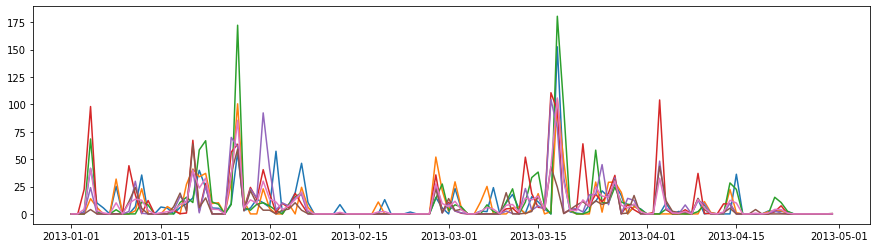

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(data['2013'])
plt.show()

##1.2. Estações Fluviométricas


Usaremos duas estações fluviométricas: 

* 59120000	MACAÉ DE CIMA
* 59125000	GALDINÓPOLIS
* 59135000	PILLER
* 59134000	BARRA DO SANA
* 59138800	FAZENDA AIRIS
* 59143000	SÃO PEDRO

As séries foram obtidas no Hidroweb e cedidas pelo Sistema de Alerta de Cheias do INEA.


**Importando os nosso dados**

In [ ]:
Estacoes_Flu_Arquivo = '/content/drive/MyDrive/IC - Aprendizado de Máquina/Banco de dados INEA/Estacoes_fluviometricas_CSV.CSV'
FluGaldi_Arquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/vazoes_C_59125000.csv'
FluMacae_Arquivo = '/content/drive/My Drive/IC - Aprendizado de Máquina/Arquivos CSV/vazoes_C_59120000.csv'
FluPiller_Arquivo = '/content/drive/MyDrive/IC - Aprendizado de Máquina/Arquivos CSV/vazoes_C_59135000.csv'

f_galdi = pd.read_csv(FluGaldi_Arquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')
f_macae = pd.read_csv(FluMacae_Arquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')
f_piller = pd.read_csv(FluPiller_Arquivo,index_col=False,skiprows=12,encoding='latin-1',sep=';')
df_flu = pd.read_csv(Estacoes_Flu_Arquivo,index_col=False,encoding='latin-1',sep=';')
df_flu.head(3)

RegistroID  Importado  Temporario  ... DataIns  DataAlt  RespAlt
0      140986          0  00/01/1900  ...     NaN      NaN      nan
1      140987          0  00/01/1900  ...     NaN      NaN      nan
2      140988          0  00/01/1900  ...     NaN      NaN      nan

[3 rows x 86 columns]

O df `df_flu` possui mais de uma série históricas. Vamos separá-las:

In [ ]:
codigo_fazenda, codigo_saopedro, codigo_sana = 59138800, 59143000, 59134000

data_flu_fazenda = df_flu.loc[df_flu.EstacaoCodigo == codigo_fazenda]
data_flu_saopedro = df_flu.loc[df_flu.EstacaoCodigo == codigo_saopedro]
data_flu_sana = df_flu.loc[df_flu.EstacaoCodigo == codigo_sana]

###**Pré-processamento**

In [ ]:
# LEITURAS EM NIVEL
colunas = data_flu_fazenda.columns[21:52]
data_flu_fazenda = preprocessamento(data_flu_fazenda,colunas,'Data','Fazendo Airis', freq = 'diaria')
data_flu_saopedro = preprocessamento(data_flu_saopedro,colunas,'Data','São Pedro', freq = 'diaria')
data_flu_sana = preprocessamento(data_flu_sana,colunas,'Data','Barra do Sana', freq = 'diaria')

# LEITURAS EM VAZÃO
colunas = f_galdi.columns[16:47]
data_flu_galdi = preprocessamento(f_galdi, colunas, 'Data', 'Galdinópolis', freq = 'diaria', inicio = '2009', fim='2014')
data_flu_macae = preprocessamento(f_macae, colunas, 'Data', 'Macaé de Cima', freq = 'diaria', inicio = '2009', fim='2014')
data_flu_piller = preprocessamento(f_piller, colunas, 'Data', 'Piller', freq = 'diaria', inicio = '2009', fim='2014')

Fazendo Airis | Observações: 1185 | Freq: diaria | Período: 01-02-2010 a 30-04-2013 | Falhas: 0
São Pedro | Observações: 851 | Freq: diaria | Período: 01-01-2011 a 30-04-2013 | Falhas: 0
Barra do Sana | Observações: 851 | Freq: diaria | Período: 01-01-2011 a 30-04-2013 | Falhas: 0
Galdinópolis | Observações: 2191 | Freq: diaria | Período: 01-01-2009 a 31-12-2014 | Falhas: 0
Macaé de Cima | Observações: 2191 | Freq: diaria | Período: 01-01-2009 a 31-12-2014 | Falhas: 0
Piller | Observações: 2191 | Freq: diaria | Período: 01-01-2009 a 31-12-2014 | Falhas: 0


###**Preenchimento das falhas**

In [ ]:
coluna  = ['Dados']

data_flu_fazenda = KNN(data_flu_fazenda, coluna)
data_flu_saopedro = KNN(data_flu_saopedro, coluna)
data_flu_sana = KNN(data_flu_sana, coluna)

data_flu_galdi = KNN(data_flu_galdi, coluna)
data_flu_macae = KNN(data_flu_macae, coluna)
data_flu_piller = KNN(data_flu_piller, coluna)

Plotando as estações que fazem leitura de nível do canal 

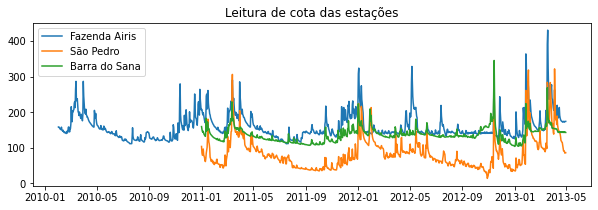

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(data_flu_fazenda['Dados'], label = 'Fazenda Airis')
plt.plot(data_flu_saopedro['Dados'], label = 'São Pedro')
plt.plot(data_flu_sana['Dados'], label = 'Barra do Sana')
plt.title('Leitura de cota das estações')
plt.legend()
plt.show()

Plotando as leituras de vazão das estações de Galdinópolis e Macaé de Cima

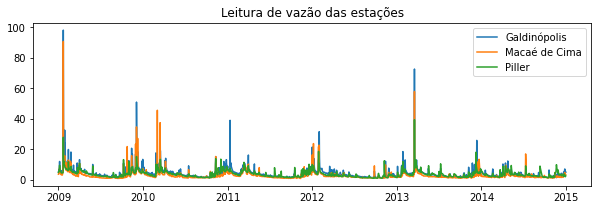

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(data_flu_galdi['Dados'], label = 'Galdinópolis')
plt.plot(data_flu_macae['Dados'], label = 'Macaé de Cima')
plt.plot(data_flu_piller['Dados'], label = 'Piller')
plt.title('Leitura de vazão das estações')
plt.legend()
plt.show()

###**Fluviograma**

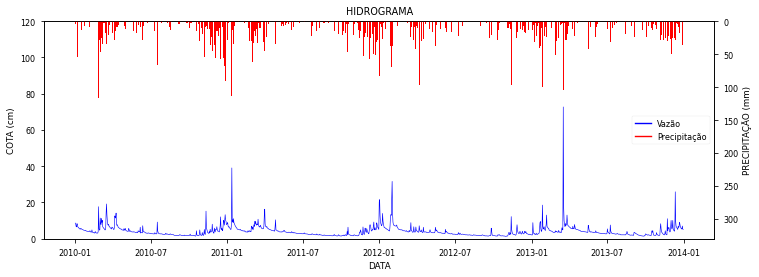

In [ ]:
hidrograma(data_flu_galdi['Dados_KNN']['2010-01':'2013-12'], 
           data_galdi['Dados_KNN']['2010-01':'2013-12'], 
           flu_ylim = 120, plu_ylim = 330, width = 2 , size = (12,4), 
           flu_ylabel = 'COTA (cm)')

# 2.Dados de Entrada

Nessa seção as estações coletadas serão analisadas a fim de formarmos as melhores alternativas de dados de entradas para os experimentos

## 2.1. Estudo de Correlação

A fim de analisar a correlação de cada estação no tempo com a variável alvo (Fazenda Airis), faremos uma matriz de correlação para cada estação com defasagens no tempo. 

In [ ]:
def matrix_corr(df_feature, df_target, delta):
  
  '''Função retorna matriz de correlação entre uma estação (df_feature) 
  em diferentes defasagens (delta) e a estação alvo (df_target)'''


  df = pd.DataFrame()
  df['Y'] = df_target

  for t in range(delta+1):
    
    df['Xt-'+str(t)] = df_feature.shift(t)

  df.dropna(inplace = True)
  matrix = df.astype('float').corr()
  matrix = matrix['Y']

  return (df,matrix)

Estação Fluviométrica **Macaé de Cima**

In [ ]:
df, mx = matrix_corr(data_flu_macae['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.50
Xt-1   0.52
Xt-2   0.45
Xt-3   0.39
Xt-4   0.36
Xt-5   0.35
Name: Y, dtype: float64

Estação Fluviométrica **Galdinópolis**

In [ ]:
df, mx = matrix_corr(data_flu_galdi['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.61
Xt-1   0.61
Xt-2   0.49
Xt-3   0.44
Xt-4   0.41
Xt-5   0.41
Name: Y, dtype: float64

Estação Fluviométrica **Piller**

In [ ]:
df, mx = matrix_corr(data_flu_piller['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.69
Xt-1   0.70
Xt-2   0.60
Xt-3   0.54
Xt-4   0.53
Xt-5   0.53
Name: Y, dtype: float64

Estação Fluviométrica **Barra do Sana**

In [ ]:
df, mx = matrix_corr(data_flu_sana['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.61
Xt-1   0.58
Xt-2   0.48
Xt-3   0.43
Xt-4   0.41
Xt-5   0.40
Name: Y, dtype: float64

Estação Fluviométrica **Fazenda Airis**

In [ ]:
df, mx = matrix_corr(data_flu_fazenda['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   1.00
Xt-1   0.89
Xt-2   0.77
Xt-3   0.72
Xt-4   0.70
Xt-5   0.67
Name: Y, dtype: float64

Estação Fluviométrica **São Pedro**

In [ ]:
df, mx = matrix_corr(data_flu_saopedro['Dados'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.71
Xt-1   0.62
Xt-2   0.52
Xt-3   0.47
Xt-4   0.43
Xt-5   0.41
Name: Y, dtype: float64

**Pluviosidade Média**

In [ ]:
df, mx = matrix_corr(data_pluvio['P_Media'], data_flu_fazenda['Dados'],5)
mx

Y      1.00
Xt-0   0.44
Xt-1   0.54
Xt-2   0.41
Xt-3   0.33
Xt-4   0.31
Xt-5   0.34
Name: Y, dtype: float64

**Observações**

De forma geral, todas as estações apresentam correlação maior em defasafem de **1 dia**. A partir disso, a correlação diminui.

## 2.2. Alternativas de Dados de Entrada

Criando um dataframe `df_entradas` que terá todas as estações disponível. 

Desse dataframe serão colhidas as variáveis de cada alternativa de entrada criada. 

In [ ]:
data_pluvio.head(3)

P_SaoJoao  P_Galdi  P_Piller  P_Ponte  P_Airis  P_Severina  P_Media
Data                                                                           
2010-01-01      13.50     4.00     10.80     0.00     0.00         nan     5.66
2010-01-02       0.00     0.00      0.00     0.00     0.00         nan     0.00
2010-01-03       0.00     0.00      0.00     0.00     0.00         nan     0.00

In [ ]:
df_entradas = pd.DataFrame()

# INSERINADO AS ESTACOES PLUVIOMETRICAS
df_entradas = data_pluvio

# INSERIANDO AS ESTACOES FLUVIOMETRICAS
coluna = 'Dados_KNN'
df_entradas['F_Macae'] = data_flu_macae[coluna]  
df_entradas['F_Galdi'] = data_flu_galdi[coluna]    
df_entradas['F_Piller'] = data_flu_piller[coluna] 
df_entradas['F_Sana'] = data_flu_sana[coluna]
df_entradas['F_Fazenda'] = data_flu_fazenda[coluna]
df_entradas['F_SaoPedro'] = data_flu_saopedro[coluna]

df_entradas.head(3)

# SALVANDO AS SERIES HISTORICAS EM CSV 
df_entradas.to_csv('/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/SeriesHistoricas.csv', decimal = ',')

**Matriz de Correlação de Pearson**

Cálculo do coeficiente de correlação entre todas as variaveis dentro do intervalo de tempo em comum entre elas

In [ ]:
data_corr = df_entradas.dropna()
data_corr = data_corr.astype('float').corr()
data_corr['F_Fazenda']

P_SaoJoao    0.41
P_Galdi      0.42
P_Piller     0.46
P_Ponte      0.30
P_Airis      0.33
P_Severina   0.28
P_Media      0.48
F_Macae      0.51
F_Galdi      0.56
F_Piller     0.66
F_Sana       0.58
F_Fazenda    1.00
F_SaoPedro   0.68
Name: F_Fazenda, dtype: float64

**As alternativas de Dados de Entrada**

A seguir, serão propostos modelos com diferentes entradas.

Tipos de análises que serão feitas:

*   Defasagem dos dados
*   Utilização da precipitação média
*   Utilização das precipitação pontualmente 
*   Estações mais a montante 
*   Somente com vazão 
*   Somente com chuva 



**Descrição das alternativas**


1.   **Todas** as estações serão aplicadas em defasagem de **1 dia**
2.   **Todas** as estações serão aplicadas em defasagem de **1 e 2 dias**
3. Somente com dados de **chuva** em defasagem de **4 dias**
4. **Precipitação média** em defasagem de **4 dias** 
5. **Precipitação média** e dados de **vazão** em defasagem de **1 dia** 
6. Somente dados de **vazão** em defasagem de **1 dia**
7. Somente com a vazão na **Fazenda Airis** em defasagem de **1 dia**
8. **Precipitação** e vazão na **Fazenda Airis** com defasagem de **1 dia** 
9. Dados de **vazão** sem a Fazenda Airis em defasagem de **1 dia** 


In [ ]:
alternativa_entrada = pd.DataFrame(index=[1,2,3,4,5,6,7,8,9])

# DEFASAGEM DOS DADOS
alternativa_entrada["Def"] = [[1], [1,2], [1,2,3,4], [1,2,3,4], [1], [1], [1], [1], [1,2]]

#ESTAÇOES PLUVIOMETRICAS
alternativa_entrada["P_SaoJoao"] =  [True, True, True, False, False, False, False, True, False]
alternativa_entrada["P_Galdi"] =    [True, True, True, False, False, False, False, True, False]
alternativa_entrada["P_Piller"] =   [True, True, True, False, False, False, False, True, False]
alternativa_entrada["P_Ponte"] =    [True, True, True, False, False, False, False, True, False]
alternativa_entrada["P_Airis"] =    [True, True, True, False, False, False, False, True, False]
alternativa_entrada["P_Severina"] = [True, True, True, False, False, False, False, True, False]
# PLUVIOSIDADE MEDIA
alternativa_entrada["P_Media"] =    [False, False, False, True, True, False, False, False, False]
# ESTAÇOES FLUVIOMETRICAS
alternativa_entrada['F_Macae'] =    [True, True, False, False, True, True, False, False, True]
alternativa_entrada['F_Galdi'] =    [True, True, False, False, True, True, False, False, True]
alternativa_entrada['F_Piller'] =   [True, True, False, False, True, True, False, False, True]
alternativa_entrada['F_Sana'] =     [True, True, False, False, True, True, False, False, True]
alternativa_entrada['F_Fazenda'] =  [True, True, False, False, True, True, True,  True, False]
alternativa_entrada['F_SaoPedro'] = [True, True, False, False, True, True, False, False, True]

alternativa_entrada

Def  P_SaoJoao  P_Galdi  ...  F_Sana  F_Fazenda  F_SaoPedro
1            [1]       True     True  ...    True       True        True
2         [1, 2]       True     True  ...    True       True        True
3   [1, 2, 3, 4]       True     True  ...   False      False       False
4   [1, 2, 3, 4]      False    False  ...   False      False       False
5            [1]      False    False  ...    True       True        True
6            [1]      False    False  ...    True       True        True
7            [1]      False    False  ...   False       True       False
8            [1]       True     True  ...   False       True       False
9         [1, 2]      False    False  ...    True      False        True
10        [2, 3]      False    False  ...    True      False        True

[10 rows x 14 columns]

# 3.Redes Neurais Artificiais

As RNAs utilizadas neste trabalho foram do tipo “MultiLayer Perceptron” (MLP) para uma tarefa de regressão. 

A abordagem será a variação entre os dados de entrada, a arquitetura da rede e suas configurações, como *função de ativação* e o uso de recursos como *dropout* e *parada antecipada*.


Para os exeperimentos, definiremos duas funções: `criando_dados` e `criando_RNA`.



### 3.1. Função `criando_dados`

A função `criando_dados` recebe a alternativa de dados de entrada que está usada na RNA e retorna os conjuntos de dados X e y. 

In [ ]:
def criando_dados(modelos_entradas,num_modelo,df_entradas, col_y):

  '''Essa função retorna:
  - data_modelo: df com todos as colunas 
  - colunas_x: df com caracteristicas
  - colunas_y: df com variavel alvo

  A última coluna será a variável alvo, e as demais serão as variáveis x

  ----

  Parâmetros:
  - `modelos_entradas`: dataframe que possui as opções de entrada que serão testadas
  - `num_modelo`: o número do modelo que será criado
  - `df_entradas`: df contendo todas as caracteristicas disponiveis
  - `col_y`: nome da coluna com a variavel alvo
  '''

  defasagem = modelos_entradas['Def'][num_modelo]
  data_modelo = pd.DataFrame()
  colunas_x = []

  # 1. CARACTERISTICAS

  for column in df_entradas:
    
    # Caso a caracteristica esteja no modelo
    if modelos_entradas.loc[num_modelo, column]:
      # Adicionando os dados em defasagem
      for i in defasagem:
        coluna = str(column) + ' T-' +str(i)
        data_modelo[coluna] = df_entradas[column].shift(i)
        #data_modelo[coluna] = df_entradas[column]
        colunas_x.append(coluna)
     
  # 2. VARIAVEL ALVO
  data_modelo['Y'] = df_entradas[col_y]

  # Excluindo as instancias com falhas que surgem quando fazemos a defasagem
  data_modelo.dropna(0,inplace=True)

  # Retornando algumas informações do modelo
  instancias, observacoes  = data_modelo.shape[0], data_modelo.size
  inicio, fim = data_modelo.index[0], data_modelo.index[instancias-1]

  modelos_entradas.loc[num_modelo,'Inicio'] = inicio
  modelos_entradas.loc[num_modelo,'Fim'] = fim
  modelos_entradas.loc[num_modelo,'Observacoes'] = observacoes

  # Retornando as colunas X e Y

  # coloquei o astype para assegurar que os dados estarão em float, 
  # já que estava ocorrendo um erro 
  colunas_y = data_modelo['Y'].astype('float')
  colunas_x = data_modelo[colunas_x].astype('float')

  print('O modelo %i possui %i observações, de %s a %s (%i meses).'%(num_modelo,
                                                          observacoes,
                                                          str(inicio),
                                                          str(fim),
                                                          instancias))
  return (data_modelo,colunas_x,colunas_y)

### 3.2. Função `criando_RNA`



A função `criando_RNA` cria e treina a RNA de forma parametrizada.

**Camadas**

* **Camdas ocultas**: 1, **2** e 4
- **Neurônios na camada oculta**: 5, 20, **50**, 80
- **Função de ativação da camada oculta**: sigmóide ou relu
- **Função de ativação da camada de saída**: **relu** ou sotfplus
- **Otimizador**: ADAM
- **Regulização**: l2

**Treinamento**

- Divisão dos dados: treinamento (60%), validação (20%) e teste (20%)
- Normalização dos dados
- Drop-out 
- Parada antecipada com 10 `epochs` de paciência
- Cada arquitetura é treinado `rep` vezes


**Métricas de Desempenho**

*   Erro médio absoluto (MAE)
*   Erro médio quadrático (MSE)
*   Coeficiente de Determinação (r2)

In [ ]:
def criando_RNA (neuronios, camadas, num_modelo, df_entradas, col_y, 
                 hidden_activation='relu', output_activation = 'relu', kernel_regularizer='l2',
                 epochs=2000, rep=10, dropout = False, n_dropout = None):
  
  '''Essa função define e treina uma RNA, dada os parâmetros:

  - `neuronios` (list): Quantidade de neuronios da camada oculta 
  - `camadas` (int ou list): Quantidade de camadas ocultas
  - `num_modelo`: Numero da alternativa de dados de entrada
  - `df_entradas`: df que reune todas as estações 
  - `col_y`: Nome da coluna com a variável alvo
  - `hidden_activation`: Nome da função da ativação. Default: 'relu'
  - `kernel_regularizer`: Nome do regularizador. Default: 'l2'
  - `epochs`: Numero máximo de epochs. Default: 800
  - `rep` (int): Numero de repetições de treinamento para cada arquitetura. Default: 10
  - `dropout` (boolean): True se quiser utilizar o dropout. Default: False
  - `n_dropout` (int): Taxa de dropout, caso dropout = True
  '''

  df, X, y = criando_dados(alternativa_entrada, num_modelo, df_entradas, col_y)
  
  y_pred = pd.DataFrame(index = df.index)

  dic_r2 = {}

  # CONFIGURANDO A PARADA ANTECIPADA
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

  checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                                                  save_best_only=True)
  
  for n_camada in camadas:
    for n_neuronios in neuronios:

      nome_modelo = 'M'+str(num_modelo)+'C'+str(n_camada)+'N'+str(n_neuronios)
      #if hidden_activation == 'relu': nome_modelo = nome_modelo + 'R'
      #if hidden_activation == 'sigmoid': nome_modelo = nome_modelo + 'S'
      #if dropout: nome_modelo = nome_modelo + 'D'

      # LISTAS COM METRICAS 
      score_list = []
      train_mae_list, train_mse_list = [],[]
      test_mae_list, test_mse_list = [],[]
      val_mae_list, val_mse_list = [], []

      for n in range(rep):
        
        # DIVISAO DOS DADOS
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
    
        # NORMALIZACAO DOS DADOS
        #scaler = StandardScaler()
        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)
      
        # CRIANDO O MODELO
        model = keras.models.Sequential()

        # CAMADA DE ENTRADA
        model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:])) 
        if dropout: model.add(keras.layers.Dropout(n_dropout))       
        
        # CAMADAS OCULTAS
        for camada in range(n_camada):
          model.add(keras.layers.Dense(n_neuronios,
                                      activation = hidden_activation,
                                      kernel_regularizer=kernel_regularizer))
          if dropout: model.add(keras.layers.Dropout(n_dropout))       
        
        # CAMADA DE SAIDA 
        model.add(keras.layers.Dense(1, activation = output_activation))

        # CONFIGURAÇOES DO TREINAMENTO 
        model.compile(loss="mae", 
                      optimizer = keras.optimizers.Adam(lr=1e-3),
                      metrics = ['mse','mae'])

        # TREINAMENTO DO MODELO
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            validation_data=(X_valid, y_valid),
                            callbacks=[checkpoint_cb, early_stopping_cb])

        history_df = pd.DataFrame(history.history)

        # PREVISAO DO MODELO
        prediction = model.predict(X_test)
        
        # AVALIACAO DO MODELO
        loss, test_mse, test_mae = model.evaluate(X_test, y_test)
        r2 = r2_score(y_test, prediction)

        if r2 >= 0:       # só irá contabilizar as inicializações que deram certo
          test_mse_list.append(test_mse)
          test_mae_list.append(test_mae)
          train_mse_list.append(history_df['mse'].min())
          train_mae_list.append(history_df['mae'].min())
          val_mse_list.append(history_df['val_mse'].min())
          val_mae_list.append(history_df['val_mae'].min())
          score_list.append(r2)

          # Salvando os valores da previsão para plotagem
          if r2 == max(score_list):
            df_true = pd.DataFrame(y_test)
            df_pred = pd.DataFrame(prediction, index = df_true.index)
          
          
      # SALVANDO AS METRICAS DEPOIS DAS REPETIÇÕES
      score, std = np.mean(score_list), np.std(score_list)
      
      dic_r2[nome_modelo] = score_list

      metricas_modelo.loc[nome_modelo,'Treino_MSE'] = np.mean(train_mse_list)
      metricas_modelo.loc[nome_modelo,'Treino_MAE'] = np.mean(train_mae_list)
      metricas_modelo.loc[nome_modelo,'Val_MSE'] = np.mean(val_mse_list)
      metricas_modelo.loc[nome_modelo,'Val_MAE'] = np.mean(val_mae_list)
      metricas_modelo.loc[nome_modelo,'Teste_MSE'] = np.mean(test_mse_list)
      metricas_modelo.loc[nome_modelo,'Teste_MAE'] = np.mean(test_mae_list)
      metricas_modelo.loc[nome_modelo,'R2'] = score
      metricas_modelo.loc[nome_modelo,'STD'] = std

      y_pred['True_' + nome_modelo] = df_true['Y']
      y_pred['Pred_' + nome_modelo] = df_pred
      y_pred.sort_index(ascending=True, inplace = True)

      print("R2 score: ","{:.2f}".format(score),"({:.2f})".format(std))
  
  print(dic_r2)
  
  return (y_pred)

###Plotando as previsões

A função `plot_resultados` será usada para gerar gráfico com: 

 *Dados Observados X Dados Previstos*.

In [ ]:
def plot_resultados (y_pred, nome_modelo, figsize = (6,3),
                     ylabel = 'Vazão (m3/s)', xlabel = 'Observações',
                     grid = True):
  
  # Conjunto de dados - resetando o index para plotar no eixo x o n de observações 
  pred = y_pred['Pred_'+nome_modelo].dropna().reset_index(drop=True)
  true = y_pred['True_'+nome_modelo].dropna().reset_index(drop=True)

  fig, ax =  plt.subplots(figsize = figsize)

  ax.plot(pred,label='Estimado',c='red',ls='--', linewidth=0.8)
  ax.plot(true,label='Observado',c='dimgrey', linewidth=0.8)
  ax.set_xlim(0, pred.size)
  ax.legend()
  ax.grid(grid)

  plt.title(nome_modelo.replace('R',''))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)  
  
  path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Plots/' + nome_modelo + '.jpeg'  
  plt.savefig(fname = path, bbox_inches='tight', pad_inches=0.1, dpi = 150)
  plt.show()


A função `plot_scatter` será usada para gerar os gráficos de dispersão.

In [ ]:
def plot_scatter (y_pred, col_true, col_pred, nome_modelo, 
             size = 6, ylabel = 'Cota Prevista', xlabel = 'Cota Observada',
             titulo = 'Gráfico de Dispersão', r2 = None):

  y, x = y_pred[col_pred], y_pred[col_true]
  
  # Gráfico de dispersao 
  plt.figure(figsize=(3,3))
  plt.scatter(y, x, s = size)

  # Linha 
  plt.plot([y.min(), y.max()], [y.min(), y.max()], '-', lw=1, color = 'black')
  

  #Plotando o coeficiente de determinação 
  if r2 != None: 
    r2_text = 'R² = ' + "{:.2f}".format(r2)
    # xy = (x.min(),y.max())
    plt.annotate(r2_text, xy = (0.05,0.9), xycoords = 'axes fraction',
                 bbox=dict(boxstyle="square", fc="1"))
  
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(titulo)

  path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Scatter/' + nome_modelo + '.jpeg'  
  plt.savefig(fname = path, bbox_inches='tight', pad_inches=0.1, dpi = 150)

  plt.plot()

Função *name_file* define o nome dos arquivos salvos com as métricas obtidas

In [ ]:
def name_file(n = 0):
  from datetime import datetime
  data = datetime.now().strftime("%d-%m")
  path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/'
  file_path = path + data + '-RNA-DIARIO-METRICAS(' + str(n) + ').csv'
  
  # Verifica se já há arquivo com esse nome 
  import os.path
  if os.path.exists(file_path): file_path = name_file(n = n+1)

  return (file_path)

## **3.2. Experimentos**

Nesta seção os experimentos serão executados. 

A implementação das RNAs está dividida entre as *alternativas de entrada*.

Cada RNA será treinada 5 vezes com inicializações aleatórias.

Após os treinamentos, as métricas obtidas serão salvas do df `metricas_modelo`, e as previsões serão salvas no df `y_pred`.

In [ ]:
# Variação da arquitetura da RNA
neuronios = [5, 10, 20, 50, 80, 100, 120]
camadas = [1, 2, 4]

# Informações para salvar os arquivos
from datetime import datetime
data = datetime.now().strftime("%d-%m")
path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/'

Criando dataframe que armazenará as métricas dos modelos.

In [ ]:
# DataFrame com as metricas do modelo
metricas_modelo = pd.DataFrame()

### Alternativa 1

In [ ]:
num_modelo = 1

# Criando as RNAs
y_pred1 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=5)

# Salvando os resultados
pred1Arquivo = path + data + '-RNA-DIARIO-YPRED1.csv'
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')
y_pred1.to_csv(pred1Arquivo, sep=';', decimal = ',')

metricas_modelo

Streaming output truncated to the last 5000 lines.
Epoch 112/2000
14/14 [==============================] - 0s 11ms/step - loss: 11.5487 - mse: 308.6623 - mae: 10.5934 - val_loss: 13.1531 - val_mse: 494.6151 - val_mae: 12.1986
Epoch 113/2000
14/14 [==============================] - 0s 9ms/step - loss: 11.2321 - mse: 307.2748 - mae: 10.2779 - val_loss: 13.1029 - val_mse: 491.5553 - val_mae: 12.1481
Epoch 114/2000
14/14 [==============================] - 0s 13ms/step - loss: 12.5700 - mse: 426.5564 - mae: 11.6146 - val_loss: 13.0539 - val_mse: 489.0258 - val_mae: 12.0988
Epoch 115/2000
14/14 [==============================] - 0s 11ms/step - loss: 12.3740 - mse: 401.1355 - mae: 11.4196 - val_loss: 13.0387 - val_mse: 491.3077 - val_mae: 12.0852
Epoch 116/2000
14/14 [==============================] - 0s 11ms/step - loss: 11.5599 - mse: 328.5721 - mae: 10.6065 - val_loss: 12.9794 - val_mse: 487.4873 - val_mae: 12.0252
Epoch 117/2000
14/14 [==============================] - 0s 10ms/step - loss

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R      248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R      199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R      232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R      198.85        6.54   169.99  ...       7.09 0.80 0.05

[4 rows x 8 columns]

### Alternativa 2


In [ ]:
num_modelo = 2

y_pred2 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=5)

pred2Arquivo = path + data + '-RNA-DIARIO-YPRED2.csv'
y_pred2.to_csv(pred2Arquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

O modelo 2 possui 18225 observações, de 2011-05-03 00:00:00 a 2013-04-30 00:00:00 (729 meses).
Epoch 1/2000
14/14 [==============================] - 1s 26ms/step - loss: 162.0370 - mse: 27740.5404 - mae: 161.2403 - val_loss: 155.4100 - val_mse: 25020.3184 - val_mae: 154.6624
Epoch 2/2000
14/14 [==============================] - 0s 8ms/step - loss: 161.6603 - mse: 27678.9030 - mae: 160.9262 - val_loss: 155.0094 - val_mse: 24906.5723 - val_mae: 154.3117
Epoch 3/2000
14/14 [==============================] - 0s 7ms/step - loss: 161.2910 - mse: 27657.3620 - mae: 160.6026 - val_loss: 154.2997 - val_mse: 24686.8809 - val_mae: 153.6356
Epoch 4/2000
14/14 [==============================] - 0s 7ms/step - loss: 159.7821 - mse: 27111.0307 - mae: 159.1234 - val_loss: 152.9053 - val_mse: 24240.9004 - val_mae: 152.2594
Epoch 5/2000
14/14 [==============================] - 0s 8ms/step - loss: 157.6099 - mse: 26341.2142 - mae: 156.9656 - val_loss: 150.0061 - val_mse: 23312.6582 - val_mae: 149.3617
Epoc

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R      248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R      199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R      232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R      198.85        6.54   169.99  ...       7.09 0.80 0.05
M2C4N20R      221.99        6.73   143.25  ...       7.06 0.78 0.04

[5 rows x 8 columns]

### Alternativa 3

In [ ]:
num_modelo = 3

y_pred3 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=5)

predArquivo = path + data + '-RNA-DIARIO-YPRED3.csv'
y_pred3.to_csv(predArquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

O modelo 3 possui 18175 observações, de 2011-05-05 00:00:00 a 2013-04-30 00:00:00 (727 meses).
Epoch 1/2000
14/14 [==============================] - 1s 27ms/step - loss: 154.9038 - mse: 24962.1134 - mae: 154.6655 - val_loss: 161.3362 - val_mse: 28035.1504 - val_mae: 161.1082
Epoch 2/2000
14/14 [==============================] - 0s 7ms/step - loss: 156.5923 - mse: 25535.6074 - mae: 156.3672 - val_loss: 161.2057 - val_mse: 27996.2129 - val_mae: 160.9887
Epoch 3/2000
14/14 [==============================] - 0s 7ms/step - loss: 156.9579 - mse: 25711.9624 - mae: 156.7432 - val_loss: 161.0489 - val_mse: 27947.6035 - val_mae: 160.8407
Epoch 4/2000
14/14 [==============================] - 0s 7ms/step - loss: 157.1731 - mse: 25870.1970 - mae: 156.9669 - val_loss: 160.8583 - val_mse: 27887.1484 - val_mae: 160.6574
Epoch 5/2000
14/14 [==============================] - 0s 7ms/step - loss: 155.8765 - mse: 25402.0639 - mae: 155.6772 - val_loss: 160.6224 - val_mse: 27811.2578 - val_mae: 160.4276
Epoc

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R      248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R      199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R      232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R      198.85        6.54   169.99  ...       7.09 0.80 0.05
M2C4N20R      221.99        6.73   143.25  ...       7.06 0.78 0.04
M3C4N5R       759.52       17.05   843.94  ...      17.86 0.26 0.18

[6 rows x 8 columns]

### Alternativa 4

In [ ]:
num_modelo = 4

y_pred4 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=7)

predArquivo = path + data + '-RNA-DIARIO-YPRED4.csv'
y_pred4.to_csv(predArquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

Streaming output truncated to the last 5000 lines.
Epoch 130/2000
23/23 [==============================] - 0s 5ms/step - loss: 21.3170 - mse: 937.6233 - mae: 20.4012 - val_loss: 21.1426 - val_mse: 815.3549 - val_mae: 20.2259
Epoch 131/2000
23/23 [==============================] - 0s 5ms/step - loss: 20.3195 - mse: 893.4413 - mae: 19.4023 - val_loss: 21.1348 - val_mse: 815.4112 - val_mae: 20.2175
Epoch 132/2000
23/23 [==============================] - 0s 5ms/step - loss: 20.9053 - mse: 977.8376 - mae: 19.9877 - val_loss: 21.1293 - val_mse: 815.3325 - val_mae: 20.2123
Epoch 133/2000
23/23 [==============================] - 0s 5ms/step - loss: 21.5754 - mse: 934.7064 - mae: 20.6585 - val_loss: 21.1154 - val_mse: 815.4531 - val_mae: 20.1986
Epoch 134/2000
23/23 [==============================] - 0s 5ms/step - loss: 21.3078 - mse: 943.1508 - mae: 20.3906 - val_loss: 21.1304 - val_mse: 814.9307 - val_mae: 20.2129
Epoch 135/2000
23/23 [==============================] - 0s 7ms/step - loss: 20.

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R      248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R      199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R      232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R      198.85        6.54   169.99  ...       7.09 0.80 0.05
M2C4N20R      221.99        6.73   143.25  ...       7.06 0.78 0.04
M3C4N5R       759.52       17.05   843.94  ...      17.86 0.26 0.18
M4C2N5R       865.12       19.83   800.78  ...      19.83 0.34 0.04
M4C2N10R      819.48       19.62   830.85  ...      20.59 0.32 0.10
M4C4N5R       848.43       19.71   882.29  ...      19.72 0.32 0.12
M4C4N10R      854.04       19.70   823.20  ...      19.94 0.33 0.07

[10 rows x 8 columns]

### Alternativa 5

In [ ]:
num_modelo = 5

y_pred5 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=7)

predArquivo = path + data + '-RNA-DIARIO-YPRED5-C4.csv'
y_pred5.to_csv(predArquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 7ms/step - loss: 7.4332 - mse: 187.0871 - mae: 6.8080 - val_loss: 10.2513 - val_mse: 489.9783 - val_mae: 9.6248
Epoch 268/2000
16/16 [==============================] - 0s 6ms/step - loss: 8.4185 - mse: 264.4023 - mae: 7.7928 - val_loss: 10.1941 - val_mse: 491.4051 - val_mae: 9.5682
Epoch 269/2000
16/16 [==============================] - 0s 7ms/step - loss: 7.8140 - mse: 239.4937 - mae: 7.1883 - val_loss: 10.1868 - val_mse: 494.5298 - val_mae: 9.5615
Epoch 270/2000
16/16 [==============================] - 0s 7ms/step - loss: 8.4479 - mse: 316.8504 - mae: 7.8225 - val_loss: 10.1810 - val_mse: 494.0985 - val_mae: 9.5557
Epoch 271/2000
16/16 [==============================] - 0s 7ms/step - loss: 8.0951 - mse: 262.8781 - mae: 7.4695 - val_loss: 10.2771 - val_mse: 500.5441 - val_mae: 9.6530
Epoch 272/2000
16/16 [==============================] - 0s 7ms/step - loss: 7.9833 - mse: 237.0216 - mae: 7.3

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R      248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R      199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R      232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R      198.85        6.54   169.99  ...       7.09 0.80 0.05
M2C4N20R      221.99        6.73   143.25  ...       7.06 0.78 0.04
M3C4N5R       759.52       17.05   843.94  ...      17.86 0.26 0.18
M4C2N5R       865.12       19.83   800.78  ...      19.83 0.34 0.04
M4C2N10R      819.48       19.62   830.85  ...      20.59 0.32 0.10
M4C4N5R       848.43       19.71   882.29  ...      19.72 0.32 0.12
M4C4N10R      854.04       19.70   823.20  ...      19.94 0.33 0.07
M5C1N5R       295.33        8.00   282.76  ...       8.24 0.76 0.10
M5C1N10R      289.82        7.59   255.78  ...       7.57 0.80 0.07
M5C1N20R      251.26        7.42   359.99  ...       8.06 0.78 0.09
M5C2N5R       243.01        7.12   320.50  ...       8.03 0.80 0.07
M5C2N10R      248.29        7.03   276.68  ...       8.20 0.75 0.09
M5C2N20R      252.04        6.92   422.52  ...       6.81 0.86 0.03
M5C4N5R       232.28        6.86   403.07  ...       7.14 0.81 0.09
M5C4N10R      305.96        7.50   174.83  ...       7.17 0.80 0.06
M5C4N20R      273.28        7.28   235.43  ...       7.66 0.79 0.06

[19 rows x 8 columns]

### Alternativa 6

In [ ]:
num_modelo = 6

y_pred6 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=5)

pred1Arquivo = path + data + '-RNA-DIARIO-YPRED6.csv'
y_pred6.to_csv(pred1Arquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')
metricas_modelo

Streaming output truncated to the last 5000 lines.
Epoch 955/2000
16/16 [==============================] - 0s 9ms/step - loss: 9.3698 - mse: 297.2166 - mae: 8.0337 - val_loss: 7.4110 - val_mse: 118.2484 - val_mae: 6.0756
Epoch 956/2000
16/16 [==============================] - 0s 8ms/step - loss: 8.0133 - mse: 219.8288 - mae: 6.6789 - val_loss: 7.4149 - val_mse: 117.9356 - val_mae: 6.0789
Epoch 957/2000
16/16 [==============================] - 0s 10ms/step - loss: 8.6101 - mse: 270.9285 - mae: 7.2755 - val_loss: 7.4103 - val_mse: 117.9507 - val_mae: 6.0765
Epoch 958/2000
16/16 [==============================] - 0s 13ms/step - loss: 7.8771 - mse: 190.7373 - mae: 6.5435 - val_loss: 7.4159 - val_mse: 118.0763 - val_mae: 6.0829
Epoch 959/2000
16/16 [==============================] - 0s 10ms/step - loss: 9.1958 - mse: 309.0287 - mae: 7.8630 - val_loss: 7.4104 - val_mse: 118.2779 - val_mae: 6.0795
Epoch 960/2000
16/16 [==============================] - 0s 8ms/step - loss: 9.3172 - mse: 285.67

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M1C1N10R       248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N50R       199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C2N10R       232.62        6.76   184.85  ...       6.60 0.86 0.06
M1C2N50R       198.85        6.54   169.99  ...       7.09 0.80 0.05
M2C4N20R       221.99        6.73   143.25  ...       7.06 0.78 0.04
M3C4N5R        759.52       17.05   843.94  ...      17.86 0.26 0.18
M4C2N5R        865.12       19.83   800.78  ...      19.83 0.34 0.04
M4C2N10R       819.48       19.62   830.85  ...      20.59 0.32 0.10
M4C4N5R        848.43       19.71   882.29  ...      19.72 0.32 0.12
M4C4N10R       854.04       19.70   823.20  ...      19.94 0.33 0.07
M5C1N5R        295.33        8.00   282.76  ...       8.24 0.76 0.10
M5C1N10R       289.82        7.59   255.78  ...       7.57 0.80 0.07
M5C1N20R       251.26        7.42   359.99  ...       8.06 0.78 0.09
M5C2N5R        243.01        7.12   320.50  ...       8.03 0.80 0.07
M5C2N10R       248.29        7.03   276.68  ...       8.20 0.75 0.09
M5C2N20R       252.04        6.92   422.52  ...       6.81 0.86 0.03
M5C4N5R        232.28        6.86   403.07  ...       7.14 0.81 0.09
M5C4N10R       305.96        7.50   174.83  ...       7.17 0.80 0.06
M5C4N20R       273.28        7.28   235.43  ...       7.66 0.79 0.06
M6C1N5R        350.30        8.28   259.15  ...       7.48 0.82 0.07
M6C1N80R       278.19        7.15   331.13  ...       7.52 0.79 0.08
M6C1N100R      254.59        7.16   420.63  ...       7.10 0.81 0.08
M6C1N120R      317.21        7.52   216.17  ...       8.01 0.79 0.07
M6C4N5R        287.60        7.22   341.34  ...       7.97 0.79 0.06
M6C4N80R       296.42        7.38   198.81  ...       7.26 0.75 0.13
M6C4N100R      296.62        7.43   238.21  ...       7.21 0.78 0.06
M6C4N120R      260.67        7.01   354.08  ...       7.17 0.78 0.11

[27 rows x 8 columns]

### Alternativa 7

In [ ]:
num_modelo = 7

y_pred7 = criando_RNA(neuronios = neuronios, camadas = camadas, 
                      num_modelo = num_modelo, df_entradas = df_entradas, 
                      col_y = 'F_Fazenda', rep=5)

pred1Arquivo = path + data + '-RNA-DIARIO-YPRED7-C4.csv'
y_pred7.to_csv(pred1Arquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

O modelo 7 possui 2368 observações, de 2010-02-02 00:00:00 a 2013-04-30 00:00:00 (1184 meses).
Epoch 1/2000
23/23 [==============================] - 1s 11ms/step - loss: 159.2458 - mse: 26630.2844 - mae: 159.0977 - val_loss: 158.6376 - val_mse: 26325.0449 - val_mae: 158.4994
Epoch 2/2000
23/23 [==============================] - 0s 3ms/step - loss: 162.1482 - mse: 27759.7052 - mae: 162.0131 - val_loss: 158.6254 - val_mse: 26325.0449 - val_mae: 158.4994
Epoch 3/2000
23/23 [==============================] - 0s 4ms/step - loss: 157.9031 - mse: 26167.0108 - mae: 157.7799 - val_loss: 158.6143 - val_mse: 26325.0449 - val_mae: 158.4994
Epoch 4/2000
23/23 [==============================] - 0s 3ms/step - loss: 159.7492 - mse: 26829.9717 - mae: 159.6369 - val_loss: 158.6041 - val_mse: 26325.0449 - val_mae: 158.4994
Epoch 5/2000
23/23 [==============================] - 0s 3ms/step - loss: 159.4959 - mse: 26890.3143 - mae: 159.3936 - val_loss: 158.5947 - val_mse: 26325.0449 - val_mae: 158.4994
Epoc

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M8C2N5R        222.95        6.83   200.87  ...       7.27 0.86 0.01
M8C2N10R       223.51        6.95   199.93  ...       6.75 0.86 0.04
M8C4N5R        208.68        6.83   209.43  ...       6.63 0.83 0.09
M8C4N10R       185.47        6.31   270.03  ...       6.94 0.83 0.04
M9C1N5R        754.17       16.20   713.57  ...      15.66 0.51 0.12
M9C1N10R       750.51       16.14   856.13  ...      15.53 0.48 0.07
M9C1N50R       677.42       15.43   655.45  ...      16.47 0.48 0.11
M9C1N80R       672.35       15.88   762.14  ...      16.47 0.44 0.08
M9C1N100R      656.22       15.51   788.50  ...      16.84 0.35 0.16
M9C1N120R      688.83       15.64   649.44  ...      16.04 0.48 0.16
M9C2N5R        711.38       15.90   522.25  ...      16.10 0.49 0.06
M9C2N10R       653.22       14.93   711.85  ...      16.51 0.45 0.04
M9C2N50R       600.83       14.18   794.65  ...      16.28 0.45 0.08
M9C2N80R       658.16       14.74   662.00  ...      15.55 0.44 0.12
M9C2N100R      621.08       14.41   804.52  ...      15.43 0.36 0.12
M9C4N5R        581.92       14.75 1,000.71  ...      15.15 0.44 0.07
M9C4N10R       710.20       15.47   665.98  ...      14.90 0.44 0.16
M9C4N120R      613.76       13.63   611.32  ...      14.09 0.53 0.05
M7C1N5R        289.89        7.71   252.14  ...       7.89 0.76 0.05
M7C1N10R       294.97        7.52   213.59  ...       7.47 0.75 0.07
M7C1N20R       251.85        7.19   251.47  ...       8.77 0.72 0.00
M7C1N50R       263.08        7.05   311.49  ...       7.83 0.75 0.04
M7C1N80R       292.84        7.28   369.07  ...       6.94 0.84 0.03
M7C2N5R        242.85        7.68   374.05  ...       6.93 0.73 0.00
M7C2N10R       284.52        7.28   315.44  ...       7.91 0.81 0.04
M7C2N20R       281.75        7.28   302.74  ...       7.80 0.79 0.05
M7C2N50R       256.36        7.27   389.42  ...       7.44 0.82 0.04
M7C2N80R       228.44        6.99   377.83  ...       8.59 0.75 0.09
M7C2N100R      248.52        7.00   250.43  ...       8.21 0.73 0.07
M7C4N5R        272.02        7.27   308.60  ...       7.64 0.79 0.03
M7C4N20R       271.54        7.36   278.09  ...       7.85 0.77 0.07
M7C4N50R       280.85        7.51   294.68  ...       7.30 0.78 0.04
M7C4N80R       253.63        7.42   315.50  ...       7.11 0.70 0.13

[33 rows x 8 columns]

### Alternativa 8

In [ ]:
num_modelo = 8

y_pred8 = criando_RNA( neuronios = neuronios, camadas = camadas, 
                               num_modelo = num_modelo, 
                               df_entradas = df_entradas, col_y = 'F_Fazenda', rep=5)

predArquivo = path + data + '-RNA-DIARIO-YPRED8.csv'
y_pred8.to_csv(predArquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

Streaming output truncated to the last 5000 lines.
Epoch 58/2000
14/14 [==============================] - 0s 7ms/step - loss: 18.8137 - mse: 919.5622 - mae: 17.4791 - val_loss: 19.8375 - val_mse: 864.4278 - val_mae: 18.5096
Epoch 59/2000
14/14 [==============================] - 0s 7ms/step - loss: 17.0249 - mse: 763.4262 - mae: 15.7006 - val_loss: 19.1590 - val_mse: 846.8039 - val_mae: 17.8457
Epoch 60/2000
14/14 [==============================] - 0s 7ms/step - loss: 18.8585 - mse: 1196.9733 - mae: 17.5488 - val_loss: 18.6243 - val_mse: 821.5987 - val_mae: 17.3272
Epoch 61/2000
14/14 [==============================] - 0s 7ms/step - loss: 19.1947 - mse: 1383.7887 - mae: 17.9019 - val_loss: 18.1578 - val_mse: 787.0770 - val_mae: 16.8783
Epoch 62/2000
14/14 [==============================] - 0s 7ms/step - loss: 17.9813 - mse: 1093.8839 - mae: 16.7057 - val_loss: 17.7429 - val_mse: 756.6457 - val_mae: 16.4793
Epoch 63/2000
14/14 [==============================] - 0s 8ms/step - loss: 16.941

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M8C2N5R       222.95        6.83   200.87  ...       7.27 0.86 0.01
M8C2N10R      223.51        6.95   199.93  ...       6.75 0.86 0.04
M8C4N5R       208.68        6.83   209.43  ...       6.63 0.83 0.09
M8C4N10R      185.47        6.31   270.03  ...       6.94 0.83 0.04

[4 rows x 8 columns]

### Alternativa 9

In [ ]:
num_modelo = 9

y_pred9 = criando_RNA( neuronios = neuronios, camadas = camadas, 
                               num_modelo = num_modelo, 
                               df_entradas = df_entradas, col_y = 'F_Fazenda', rep=5)

pred1Arquivo = path + data + '-RNA-DIARIO-YPRED9-C4.csv'
y_pred9.to_csv(pred1Arquivo, sep=';', decimal = ',')
metricas_modelo.to_csv(name_file(), sep=';', decimal = ',')

metricas_modelo

O modelo 9 possui 9339 observações, de 2011-01-03 00:00:00 a 2013-04-30 00:00:00 (849 meses).
Epoch 1/2000
16/16 [==============================] - 1s 15ms/step - loss: 161.3379 - mse: 27357.7188 - mae: 161.1065 - val_loss: 165.4503 - val_mse: 29186.7656 - val_mae: 165.2283
Epoch 2/2000
16/16 [==============================] - 0s 4ms/step - loss: 159.8064 - mse: 26818.8042 - mae: 159.5873 - val_loss: 165.3978 - val_mse: 29173.0859 - val_mae: 165.1874
Epoch 3/2000
16/16 [==============================] - 0s 5ms/step - loss: 159.3519 - mse: 26527.3741 - mae: 159.1444 - val_loss: 165.3342 - val_mse: 29155.7734 - val_mae: 165.1351
Epoch 4/2000
16/16 [==============================] - 0s 5ms/step - loss: 159.3699 - mse: 26529.1399 - mae: 159.1735 - val_loss: 165.2620 - val_mse: 29135.3418 - val_mae: 165.0735
Epoch 5/2000
16/16 [==============================] - 0s 4ms/step - loss: 160.3118 - mse: 26861.9164 - mae: 160.1258 - val_loss: 165.1829 - val_mse: 29112.1973 - val_mae: 165.0042
Epoch

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
M8C2N5R        222.95        6.83   200.87  ...       7.27 0.86 0.01
M8C2N10R       223.51        6.95   199.93  ...       6.75 0.86 0.04
M8C4N5R        208.68        6.83   209.43  ...       6.63 0.83 0.09
M8C4N10R       185.47        6.31   270.03  ...       6.94 0.83 0.04
M9C1N5R        754.17       16.20   713.57  ...      15.66 0.51 0.12
M9C1N10R       750.51       16.14   856.13  ...      15.53 0.48 0.07
M9C1N50R       677.42       15.43   655.45  ...      16.47 0.48 0.11
M9C1N80R       672.35       15.88   762.14  ...      16.47 0.44 0.08
M9C1N100R      656.22       15.51   788.50  ...      16.84 0.35 0.16
M9C1N120R      688.83       15.64   649.44  ...      16.04 0.48 0.16
M9C2N5R        711.38       15.90   522.25  ...      16.10 0.49 0.06
M9C2N10R       653.22       14.93   711.85  ...      16.51 0.45 0.04
M9C2N50R       600.83       14.18   794.65  ...      16.28 0.45 0.08
M9C2N80R       658.16       14.74   662.00  ...      15.55 0.44 0.12
M9C2N100R      621.08       14.41   804.52  ...      15.43 0.36 0.12
M9C4N5R        581.92       14.75 1,000.71  ...      15.15 0.44 0.07
M9C4N10R       710.20       15.47   665.98  ...      14.90 0.44 0.16
M9C4N120R      613.76       13.63   611.32  ...      14.09 0.53 0.05

[18 rows x 8 columns]

# 4.Resultados

**Resumo dos resultados**

Em `alternativa_entrada` ficara um resumo com a melhor configuração de RNA para cada alternativa de entrada, assim como o coeficiente R2 do modelo correspondente.

In [ ]:
def salvar_melhor_metrica(metricas_modelo = metricas_modelo, 
                          alternativa_entrada = alternativa_entrada, 
                          intervalo = alternativa_entrada.index):

  for num_modelo in intervalo:

    # Prefixo do modelo
    nome = 'M'+str(num_modelo) 

    # Somente os modelos com a alternativa desejada
    metricas_parcial = metricas_modelo[metricas_modelo.index.str.contains(nome)]

    # Salvando o melhor coeficiente de determinação encontrado
    r2_max = metricas_parcial.loc[:,'R2'].max()
    alternativa_entrada.loc[num_modelo, 'R2'] = r2_max 
    
    # Salvando o melhor modelo correspondente
    melhor_arquitetura = metricas_parcial[metricas_parcial.loc[:,'R2'] == r2_max].index.to_list()
    alternativa_entrada.loc[num_modelo, 'Modelo'] = melhor_arquitetura[0]

Usar esse código para registrar o melhor modelo de cada alternativa no df `alternativas_entrada`.

In [ ]:
salvar_melhor_metrica(metricas_modelo_final, intervalo=[1,9])
alternativa_entrada[['R2', 'Modelo']]

R2    Modelo
1  0.88    M1C2N5
2  0.87    M2C1N5
3  0.49   M3C1N20
4  0.45   M4C4N20
5  0.86    M5C4N5
6  0.86   M6C4N20
7  0.84   M7C1N80
8  0.88    M8C1N5
9  0.53  M9C4N100
10  nan   M10C1N5

Usar esse código abaixo para exportar o df `alternativas_entrada` como csv

In [ ]:
# Salvando as alternativas de entrada dos experimentos
entradasArquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/17-05-RNA-DIARIO-ENTRADAS-ATUAL.csv'
alternativa_entrada.to_csv(entradasArquivo, sep=';', decimal = ',')

Importando o df que possui as melhores métricas obtidas após todos os experimentos.

In [ ]:
metricas_arq =  '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/17-05-RNA-DIARIO-METRICAS-ATUAL.csv'
metricas_modelo_final = pd.read_csv(metricas_arq, index_col=0, sep=';', decimal=',')
metricas_modelo_final

Treino_MSE  Treino_MAE  Val_MSE  ...  Teste_MAE   R2  STD
Modelo                                     ...                     
M1C1N5        248.68        7.74   252.86  ...       7.13 0.82 0.09
M1C1N10       248.02        7.32   229.24  ...       7.26 0.82 0.06
M1C1N20       206.51        6.68   253.06  ...       6.76 0.84 0.05
M1C1N50       199.51        6.51   196.18  ...       7.15 0.79 0.04
M1C1N80       221.09        6.60   264.39  ...       6.64 0.85 0.02
...              ...         ...      ...  ...        ...  ...  ...
M9C4N20       670.61       15.32   681.07  ...      15.53 0.42 0.08
M9C4N50       584.76       13.85   791.22  ...      16.32 0.27 0.05
M9C4N80       620.28       13.76   689.29  ...      14.73 0.46 0.11
M9C4N100      566.72       12.94   839.45  ...      13.06 0.53 0.22
M9C4N120      613.76       13.63   611.32  ...      14.09 0.53 0.05

[189 rows x 8 columns]

Importando o df `alternativas_entrada` que reune os melhores resultados

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/17-05-RNA-DIARIO-ENTRADAS-ATUAL.csv'
alternativa_entrada = pd.read_csv(Arquivo, sep=';', decimal=',', index_col=0)
alternativa_entrada[['R2', 'Modelo']]
#alternativa_entrada['Modelo'] = alternativa_entrada['Modelo'].replace("R","", regex = True)

R2    Modelo
1  0.88    M1C2N5
2  0.87    M2C1N5
3  0.49   M3C1N20
4  0.45   M4C4N20
5  0.86    M5C4N5
6  0.86   M6C4N20
7  0.84   M7C1N80
8  0.88    M8C1N5
9  0.53  M9C4N100
10 0.38   M10C1N5

## Plotando os resultados

Nessa seção os melhores resultados obtidos serão importados para plotarmos os gráficos de previsões e os gráficos de dispersão.

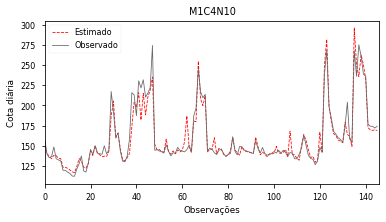

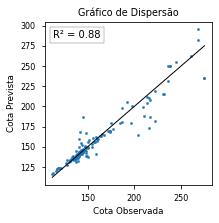

In [ ]:
# Importando o arquico com as previsões da melhore RNA 
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/17-04-RNA-DIARIO-YPRED1.csv'
y_pred1 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')

# Obtendo o coeficiente de determinação do melhor modelo
#modelo = alternativa_entrada.loc[1, 'Modelo'] 
modelo = 'M1C4N10R'
r2 = alternativa_entrada.loc[1, 'R2']

# Plotando os resultados
pred, true = 'Pred_'+ modelo , 'True_'+ modelo
plot_resultados(y_pred1, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred1, pred, true, modelo, r2=r2)

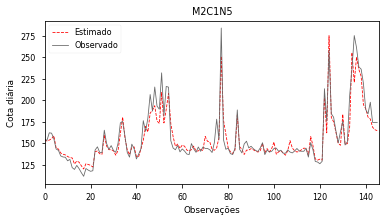

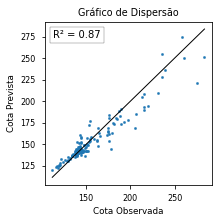

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/17-04-RNA-DIARIO-YPRED2.csv'
y_pred2 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[2, 'Modelo'] + "R"
r2 = alternativa_entrada.loc[2, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo 

plot_resultados(y_pred2, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred2, pred, true, modelo, r2=r2)

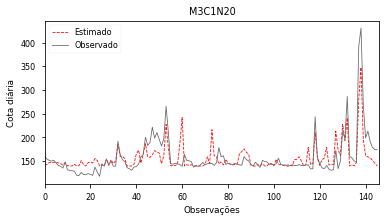

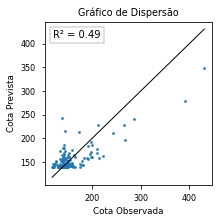

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/01-05-RNA-DIARIO-YPRED3(1).csv'
y_pred3 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[3, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[3, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred3, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred3, pred, true, modelo, r2=r2)

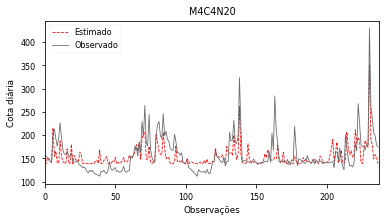

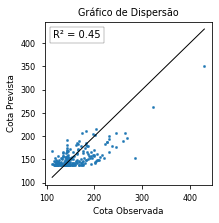

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/01-05-RNA-DIARIO-YPRED4(1).csv'
y_pred4 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[4, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[4, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred4, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred4, pred, true, modelo, r2=r2)

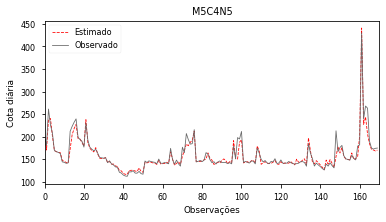

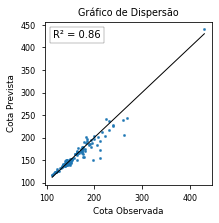

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/21-04-RNA-DIARIO-YPRED5.csv'
y_pred5 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[5, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[5, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred5, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred5, pred, true, modelo, r2=r2)

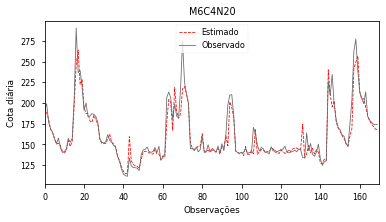

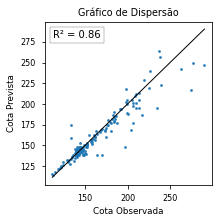

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/19-04-RNA-DIARIO-YPRED6.csv'
y_pred6 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[6, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[6, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred6, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred6, pred, true, modelo,r2=r2)

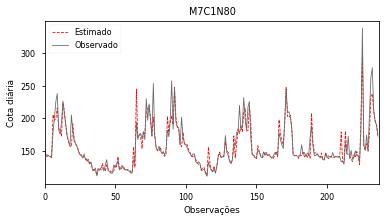

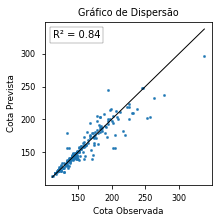

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/16-05-RNA-DIARIO-YPRED7-C1.csv'
y_pred7 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[7, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[7, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred7, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred7, pred, true, modelo, r2=r2)

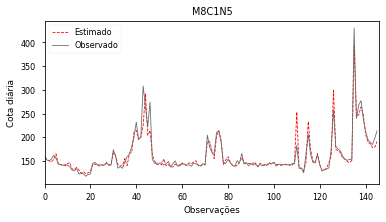

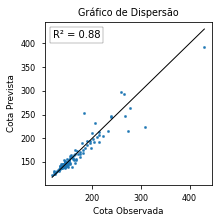

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/07-05-RNA-DIARIO-YPRED8.csv'
y_pred8 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[8, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[8, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred8, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred8, pred, true, modelo, r2=r2)

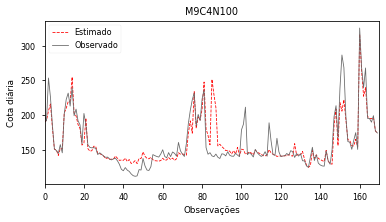

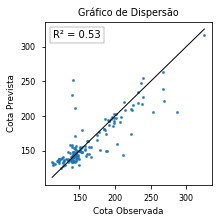

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/20-04-RNA-DIARIO-YPRED9.csv'
y_pred9 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[9, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[9, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred9, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred9, pred, true, modelo, r2=r2)

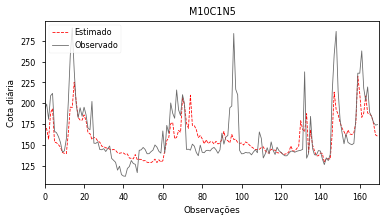

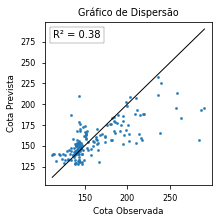

In [ ]:
Arquivo = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/Ultimo Experimento/20-04-RNA-DIARIO-YPRED10.csv'
y_pred10 = pd.read_csv(Arquivo, sep = ';', index_col = 0, decimal = ',')
modelo = alternativa_entrada.loc[10, 'Modelo'] + 'R'
r2 = alternativa_entrada.loc[10, 'R2']
pred, true = 'Pred_'+ modelo, 'True_'+ modelo

plot_resultados(y_pred10, modelo, grid=False, ylabel = 'Cota diária')
plot_scatter(y_pred10, pred, true, modelo, r2=r2)

# 5.Outros Algoritmos

## 5.1. Árvore de Decisão de Regressão

In [ ]:
from sklearn.metrics import r2_score
def decision_tree (num_modelo, df_entradas, col_y, df_metricas, rep=10):
  
  # Criando os conjuntos de dados 
  df, X, y = criando_dados(alternativa_entrada, num_modelo, df_entradas, col_y)

  nome_modelo = 'M'+str(num_modelo)
  score_list = []

  # IMPLEMENTANDO O MODELO
  for n in range(rep):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    # NORMALIZACAO DOS DADOS
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  
    tree_regr = DecisionTreeRegressor(criterion = 'mae')
    
    tree_regr.fit(X_train, y_train)
    
    y_pred = tree_regr.predict(X_test)
    
    r2 = tree_regr.score(X_test, y_test)
    score_list.append(r2)

  # SALVANDO SO RESULTADOS
  r2_score, std =  np.mean(score_list), np.std(score_list)
  df_metricas.loc[nome_modelo,'R2_DT'] = r2_score
  df_metricas.loc[nome_modelo,'R2_DT_std'] = std
  # df_metricas.loc[nome_modelo,'Depth'] = tree_regr.get_depth()
  # df_metricas.loc[nome_modelo,'Leaves'] = tree_regr.get_n_leaves()

  return (y_pred)

##5.2 Redes Neurais Recorrentes

In [ ]:
from keras.layers import LSTM

def RNN(num_modelo, df_entradas, col_y, df_metricas, n_epochs=400): 

  # Criando os conjuntos de dados 
  df, X, y = criando_dados(alternativa_entrada, num_modelo, df_entradas, col_y)

  nome_modelo = 'M'+str(num_modelo)
  score_list = []

  # DIVISAO DOS CONJUNTO DE DADOS
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)
  # NORMALIZACAO DOS DADOS
  scaler = MinMaxScaler(feature_range=(0,1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  # RESHAPE DOS DADOS PARA FORMATO 3D: [SAMPLES, TIMESTEP, FEATURES]
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

  # IMPLEMENTANDO O MODELO
  model = keras.models.Sequential()
  model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  model.fit(X_train, y_train, epochs = n_epochs, batch_size = 1, verbose = 2)
  
  # PREVISAO
  pred = model.predict(X_test)
  y_pred = pd.DataFrame(pred)
   
  # INVERTENDO A NORMALIZACAO
  #testPred = scaler.inverse_transform([testPred])

  # SALVANDO OS RESULTADOS
  r2 = r2_score(y_test, y_pred)
  print('R2 score: %.2f' %(r2))
  df_metricas.loc[nome_modelo,'RNN_LR'] = r2_score

  return (y_pred)

## 5.4 Experimentos

In [ ]:
metricas_tree = pd.DataFrame()

# Aplicando os modelos
for num_modelo in alternativa_entrada.index:
  decision_tree(num_modelo, df_entradas, 'F_Fazenda', metricas_tree)
  RNN(num_modelo, df_entradas, 'F_Fazenda', metricas_tree, n_epochs=50)

# Salvando os resultados
data = datetime.now().strftime("%d-%m")
path = '/content/drive/MyDrive/Colab Notebooks/Notebooks - TCC /Resultados/'
metricasTreeArquivo = path + data + '-TREE-REGR-METRICAS.csv'
metricas_tree.to_csv(metricasTreeArquivo, sep=';', decimal = ',')

# Exibindo os resultados
metricas_tree

O modelo 1 possui 9490 observações, de 2011-05-02 00:00:00 a 2013-04-30 00:00:00 (730 meses).


ic| X_train: array([[[0.        , 0.        , 0.        , ..., 0.10887272,
                      0.2759385 , 0.352932  ]],
             
                    

O modelo 1 possui 9490 observações, de 2011-05-02 00:00:00 a 2013-04-30 00:00:00 (730 meses).
O modelo 1 possui 9490 observações, de 2011-05-02 00:00:00 a 2013-04-30 00:00:00 (730 meses).


[[0.        , 0.        , 0.        , ..., 0.10472052,
                      0.24815251, 0.33432771]],
             
                    [[0.0281155 , 0.03726708, 0.09626274, ..., 0.10778011,
                      0.23634716, 0.33256169]],
             
                    ...,
             
                    [[0.        , 0.        , 0.        , ..., 0.05314699,
                      0.16460328, 0.25064783]],
             
                    [[0.05167173, 0.        , 0.        , ..., 0.12403884,
                      0.15850869, 0.31293665]],
             
                    [[0.15349544, 0.14596273, 0.12231031, ..., 0.12530599,
                      0.28294476, 0.23871583]]])
ic| X_test: array([[[0.24924012, 0.1252588 , 0.09286523, ..., 0.0902098 ,
                     0.23745096, 0.17646618]],
            
                   [[0.        , 0.        , 0.        , ..., 0.05694966,
                     0.18048768, 0.16088381]],
            
                   [[0.        , 0.      

Epoch 1/50
584/584 - 2s - loss: 141.9352
Epoch 2/50
584/584 - 1s - loss: 106.9992
Epoch 3/50
584/584 - 1s - loss: 74.2823
Epoch 4/50
584/584 - 1s - loss: 45.7178
Epoch 5/50
584/584 - 1s - loss: 22.6897
Epoch 6/50
584/584 - 1s - loss: 14.9850
Epoch 7/50
584/584 - 1s - loss: 14.8030
Epoch 8/50
584/584 - 1s - loss: 14.7574
Epoch 9/50
584/584 - 1s - loss: 14.6650
Epoch 10/50
584/584 - 1s - loss: 14.5657
Epoch 11/50
584/584 - 1s - loss: 14.4513
Epoch 12/50
584/584 - 1s - loss: 14.3127
Epoch 13/50
584/584 - 1s - loss: 14.1275
Epoch 14/50
584/584 - 1s - loss: 13.8954
Epoch 15/50
584/584 - 1s - loss: 13.5614
Epoch 16/50
584/584 - 1s - loss: 13.1097
Epoch 17/50
584/584 - 1s - loss: 12.5068
Epoch 18/50
584/584 - 1s - loss: 11.7846
Epoch 19/50
584/584 - 1s - loss: 11.0544
Epoch 20/50
584/584 - 1s - loss: 10.3874
Epoch 21/50
584/584 - 1s - loss: 9.8126
Epoch 22/50
584/584 - 1s - loss: 9.5217
Epoch 23/50
584/584 - 1s - loss: 9.2130
Epoch 24/50
584/584 - 1s - loss: 8.9570
Epoch 25/50
584/584 - 1s - 

ic| X_train: array([[[0.        , 

O modelo 2 possui 18225 observações, de 2011-05-03 00:00:00 a 2013-04-30 00:00:00 (729 meses).
O modelo 2 possui 18225 observações, de 2011-05-03 00:00:00 a 2013-04-30 00:00:00 (729 meses).


0.        , 0.        , ..., 0.2759385 ,
                      0.33432771, 0.352932  ]],
             
                    [[0.0281155 , 0.        , 0.03726708, ..., 0.24815251,
                      0.33256169, 0.33432771]],
             
                    [[0.        , 0.0281155 , 0.        , ..., 0.23634716,
                      0.32471151, 0.33256169]],
             
                    ...,
             
                    [[0.        , 0.        , 0.        , ..., 0.19349264,
                      0.25064783, 0.24746841]],
             
                    [[0.05167173, 0.        , 0.        , ..., 0.16460328,
                      0.31293665, 0.25064783]],
             
                    [[0.15349544, 0.05167173, 0.14596273, ..., 0.15850869,
                      0.23871583, 0.31293665]]])
ic| X_test: array([[[0.24924012, 0.15349544, 0.1252588 , ..., 0.28294476,
                     0.17646618, 0.23871583]],
            
                   [[0.        , 0.24924012, 0.     

Epoch 1/50
583/583 - 2s - loss: 140.1784
Epoch 2/50
583/583 - 1s - loss: 104.6754
Epoch 3/50
583/583 - 1s - loss: 73.8001
Epoch 4/50
583/583 - 1s - loss: 46.6833
Epoch 5/50
583/583 - 1s - loss: 24.1503
Epoch 6/50
583/583 - 1s - loss: 15.2958
Epoch 7/50
583/583 - 1s - loss: 14.9243
Epoch 8/50
583/583 - 1s - loss: 14.8419
Epoch 9/50
583/583 - 1s - loss: 14.7488
Epoch 10/50
583/583 - 1s - loss: 14.6131
Epoch 11/50
583/583 - 1s - loss: 14.4011
Epoch 12/50
583/583 - 1s - loss: 14.0808
Epoch 13/50
583/583 - 1s - loss: 13.4999
Epoch 14/50
583/583 - 1s - loss: 12.7082
Epoch 15/50
583/583 - 1s - loss: 11.9324
Epoch 16/50
583/583 - 1s - loss: 11.5504
Epoch 17/50
583/583 - 1s - loss: 11.2081
Epoch 18/50
583/583 - 1s - loss: 10.9261
Epoch 19/50
583/583 - 1s - loss: 10.6903
Epoch 20/50
583/583 - 1s - loss: 10.4680
Epoch 21/50
583/583 - 1s - loss: 10.2003
Epoch 22/50
583/583 - 1s - loss: 10.0566
Epoch 23/50
583/583 - 1s - loss: 9.8586
Epoch 24/50
583/583 - 1s - loss: 9.6948
Epoch 25/50
583/583 - 1s 

ic| X_train: array([[[0.        , 0.        , 0.        , ..., 0.        ,
                      0.05451519, 0.05451519]],
             
                    [[0.0281155 , 0.        , 0.03726708, ..., 0.

O modelo 3 possui 9477 observações, de 2011-05-03 00:00:00 a 2013-04-30 00:00:00 (729 meses).
O modelo 3 possui 9477 observações, de 2011-05-03 00:00:00 a 2013-04-30 00:00:00 (729 meses).


        ,
                      0.05451519, 0.05451519]],
             
                    [[0.        , 0.0281155 , 0.        , ..., 0.        ,
                      0.05451519, 0.05451519]],
             
                    ...,
             
                    [[0.        , 0.        , 0.        , ..., 0.        ,
                      0.        , 0.        ]],
             
                    [[0.05167173, 0.        , 0.        , ..., 0.        ,
                      0.05925926, 0.        ]],
             
                    [[0.15349544, 0.05167173, 0.14596273, ..., 0.03465346,
                      0.0037037 , 0.05925926]]])
ic| X_test: array([[[0.24924012, 0.15349544, 0.1252588 , ..., 0.        ,
                     0.        , 0.0037037 ]],
            
                   [[0.        , 0.24924012, 0.        , ..., 0.        ,
                     0.        , 0.        ]],
            
                   [[0.        , 0.        , 0.        , ..., 0.        ,
            

Epoch 1/50
583/583 - 2s - loss: 144.7990
Epoch 2/50
583/583 - 1s - loss: 112.7900
Epoch 3/50
583/583 - 1s - loss: 77.8062
Epoch 4/50
583/583 - 1s - loss: 46.7749
Epoch 5/50
583/583 - 1s - loss: 22.7275
Epoch 6/50
583/583 - 1s - loss: 15.2880
Epoch 7/50
583/583 - 1s - loss: 15.1604
Epoch 8/50
583/583 - 1s - loss: 15.1584
Epoch 9/50
583/583 - 1s - loss: 15.1429
Epoch 10/50
583/583 - 1s - loss: 15.1446
Epoch 11/50
583/583 - 1s - loss: 15.1393
Epoch 12/50
583/583 - 1s - loss: 15.1227
Epoch 13/50
583/583 - 1s - loss: 15.1377
Epoch 14/50
583/583 - 1s - loss: 15.1214
Epoch 15/50
583/583 - 1s - loss: 15.1123
Epoch 16/50
583/583 - 1s - loss: 15.1026
Epoch 17/50
583/583 - 1s - loss: 15.1118
Epoch 18/50
583/583 - 1s - loss: 15.0970
Epoch 19/50
583/583 - 1s - loss: 15.0989
Epoch 20/50
583/583 - 1s - loss: 15.0973
Epoch 21/50
583/583 - 1s - loss: 15.0839
Epoch 22/50
583/583 - 1s - loss: 15.0706
Epoch 23/50
583/583 - 1s - loss: 15.0706
Epoch 24/50
583/583 - 1s - loss: 15.0717
Epoch 25/50
583/583 - 1

ic| X_train: array([[[0.        , 0.        ]],
             
                    [[0.        , 0.        ]],
             
                    [[0.        , 0.        ]],
             
                    ...,
             
                    [[0.00033367, 0.00033367]],
             
                    [[0.        , 

O modelo 4 possui 3555 observações, de 2010-02-01 00:00:00 a 2013-04-30 00:00:00 (1185 meses).
O modelo 4 possui 3555 observações, de 2010-02-01 00:00:00 a 2013-04-30 00:00:00 (1185 meses).


0.00033367]],
             
                    [[0.0642309 , 0.        ]]])
ic| X_test: array([[[2.25225227e-02, 6.42308992e-02]],
            
                   [[1.38471806e-02, 2.25225227e-02]],
            
                   [[0.00000000e+00, 1.38471806e-02]],
            
                   [[0.00000000e+00, 0.00000000e+00]],
            
                   [[0.00000000e+00, 0.00000000e+00]],
            
                   [[0.00000000e+00, 0.00000000e+00]],
            
                   [[3.33667007e-04, 0.00000000e+00]],
            
                   [[0.00000000e+00, 3.33667007e-04]],
            
                   [[1.10110113e-02, 0.00000000e+00]],
            
                   [[2.65265266e-02, 1.10110113e-02]],
            
                   [[3.83717053e-03, 2.65265266e-02]],
            
                   [[0.00000000e+00, 3.83717053e-03]],
            
                   [[0.00000000e+00, 0.00000000e+00]],
            
                   [[0.00000000e+00, 0.

Epoch 1/50
948/948 - 4s - loss: 140.1896
Epoch 2/50
948/948 - 1s - loss: 83.1110
Epoch 3/50
948/948 - 1s - loss: 36.3097
Epoch 4/50
948/948 - 1s - loss: 22.7898
Epoch 5/50
948/948 - 1s - loss: 22.5231
Epoch 6/50
948/948 - 1s - loss: 22.4514
Epoch 7/50
948/948 - 1s - loss: 22.3498
Epoch 8/50
948/948 - 1s - loss: 22.2439
Epoch 9/50
948/948 - 1s - loss: 22.1190
Epoch 10/50
948/948 - 1s - loss: 21.9751
Epoch 11/50
948/948 - 1s - loss: 21.8367
Epoch 12/50
948/948 - 1s - loss: 21.6709
Epoch 13/50
948/948 - 1s - loss: 21.5087
Epoch 14/50
948/948 - 1s - loss: 21.3641
Epoch 15/50
948/948 - 1s - loss: 21.2023
Epoch 16/50
948/948 - 1s - loss: 21.0640
Epoch 17/50
948/948 - 1s - loss: 20.9351
Epoch 18/50
948/948 - 1s - loss: 20.8075
Epoch 19/50
948/948 - 1s - loss: 20.7278
Epoch 20/50
948/948 - 1s - loss: 20.6314
Epoch 21/50
948/948 - 1s - loss: 20.5686
Epoch 22/50
948/948 - 1s - loss: 20.4998
Epoch 23/50
948/948 - 1s - loss: 20.4545
Epoch 24/50
948/948 - 1s - loss: 20.4003
Epoch 25/50
948/948 - 1s

ic| X_train: array([[[0.10743185, 0.15463105, 0.18508119, ..., 0.43192287,
                      0.44658793, 0.30711602]],
             
                    [[0.13635581, 0.16772498, 0.20070991, ..., 0.36683182,
                      0.44241308, 0.24391538]],
             
                    [[0.0210043 

O modelo 5 possui 6800 observações, de 2011-01-02 00:00:00 a 2013-04-30 00:00:00 (850 meses).
O modelo 5 possui 6800 observações, de 2011-01-02 00:00:00 a 2013-04-30 00:00:00 (850 meses).


, 0.15463105, 0.15141321, ..., 0.31948535,
                      0.39979863, 0.22218265]],
             
                    ...,
             
                    [[0.21779053, 0.02102036, 0.05721703, ..., 0.55110065,
                      0.1415205 , 0.16130203]],
             
                    [[0.26484935, 0.01777972, 0.02370798, ..., 0.64494097,
                      0.13504174, 0.20847913]],
             
                    [[0.27747489, 0.01777972, 0.02847607, ..., 0.55562215,
                      0.13485011, 0.15287986]]])
ic| X_test: array([[[0.07575323, 0.024261  , 0.04900532, ..., 0.64460019,
                     0.14747091, 0.1807511 ]],
            
                   [[0.08608321, 0.01777972, 0.03093958, ..., 0.62139551,
                     0.15260581, 0.09749503]],
            
                   [[0.98421807, 0.38690607, 0.28860163, ..., 1.35898356,
                     0.58153386, 0.76497035]],
            
                   ...,
            
                   

Epoch 1/50
680/680 - 2s - loss: 144.2937
Epoch 2/50
680/680 - 1s - loss: 102.9422
Epoch 3/50
680/680 - 1s - loss: 66.6805
Epoch 4/50
680/680 - 1s - loss: 35.8256
Epoch 5/50
680/680 - 1s - loss: 19.5460
Epoch 6/50
680/680 - 1s - loss: 18.5146
Epoch 7/50
680/680 - 1s - loss: 18.3037
Epoch 8/50
680/680 - 1s - loss: 18.0152
Epoch 9/50
680/680 - 1s - loss: 17.6289
Epoch 10/50
680/680 - 1s - loss: 17.1644
Epoch 11/50
680/680 - 1s - loss: 16.5674
Epoch 12/50
680/680 - 1s - loss: 15.8365
Epoch 13/50
680/680 - 1s - loss: 14.8916
Epoch 14/50
680/680 - 1s - loss: 13.7255
Epoch 15/50
680/680 - 1s - loss: 12.3779
Epoch 16/50
680/680 - 1s - loss: 11.1173
Epoch 17/50
680/680 - 1s - loss: 10.3617
Epoch 18/50
680/680 - 1s - loss: 9.8875
Epoch 19/50
680/680 - 1s - loss: 9.5324
Epoch 20/50
680/680 - 1s - loss: 9.2461
Epoch 21/50
680/680 - 1s - loss: 9.0299
Epoch 22/50
680/680 - 1s - loss: 8.8529
Epoch 23/50
680/680 - 1s - loss: 8.7168
Epoch 24/50
680/680 - 1s - loss: 8.5568
Epoch 25/50
680/680 - 1s - los

ic| X_train: array([[[0.15463105, 0.18508119, 0.33248429, 0.43192287, 0.44658793,
                      0.30711602]],
             
                    [[0.16772498, 0.20070991, 0.30593762, 0.36683182, 0.44241308,
                      0.24391538]],
             
                    [[0.15463105, 0.15141321, 0.30593762, 0.31948535, 0.39979863,
                      

O modelo 6 possui 5950 observações, de 2011-01-02 00:00:00 a 2013-04-30 00:00:00 (850 meses).


0.22218265]],
             
                    ...,
             
                    [[0.02102036, 0.05721703, 0.65200657, 0.55110065, 0.1415205 ,
                      0.16130203]],
             
                    [[0.01777972, 0.02370798, 0.292919  , 0.64494097, 0.13504174,
                      0.20847913]],
             
                    [[0.01777972, 0.02847607, 0.14099734, 0.55562215, 0.13485011,
                      0.15287986]]])
ic| X_test: array([[[0.024261  , 0.04900532, 0.10590366, 0.64460019, 0.14747091,
                     0.1807511 ]],
            
                   [[0.01777972, 0.03093958, 0.07341371, 0.62139551, 0.15260581,
                     0.09749503]],
            
                   [[0.38690607, 0.28860163, 0.05196128, 1.35898356, 0.58153386,
                     0.76497035]],
            
                   ...,
            
                   [[0.06792205, 0.08669969, 0.17309107, 0.29559835, 0.27896161,
                     0.2602243 ]],
          

Epoch 1/50
680/680 - 2s - loss: 144.5432
Epoch 2/50
680/680 - 1s - loss: 103.3768
Epoch 3/50
680/680 - 1s - loss: 67.0814
Epoch 4/50
680/680 - 1s - loss: 36.2387
Epoch 5/50
680/680 - 1s - loss: 19.7959
Epoch 6/50
680/680 - 1s - loss: 18.5629
Epoch 7/50
680/680 - 1s - loss: 18.3593
Epoch 8/50
680/680 - 1s - loss: 18.0721
Epoch 9/50
680/680 - 1s - loss: 17.7099
Epoch 10/50
680/680 - 1s - loss: 17.2394
Epoch 11/50
680/680 - 1s - loss: 16.6848
Epoch 12/50
680/680 - 1s - loss: 15.9764
Epoch 13/50
680/680 - 1s - loss: 15.0976
Epoch 14/50
680/680 - 1s - loss: 13.9982
Epoch 15/50
680/680 - 1s - loss: 12.7006
Epoch 16/50
680/680 - 1s - loss: 11.2640
Epoch 17/50
680/680 - 1s - loss: 10.3834
Epoch 18/50
680/680 - 1s - loss: 9.8626
Epoch 19/50
680/680 - 1s - loss: 9.5209
Epoch 20/50
680/680 - 1s - loss: 9.2429
Epoch 21/50
680/680 - 1s - loss: 9.0970
Epoch 22/50
680/680 - 1s - loss: 8.9318
Epoch 23/50
680/680 - 1s - loss: 8.7983
Epoch 24/50
680/680 - 1s - loss: 8.6517
Epoch 25/50
680/680 - 1s - los

ic| X_train: array([[[2.16959597e-01]],
             
                    [[2.17631353e-01]],


O modelo 7 possui 2368 observações, de 2010-02-02 00:00:00 a 2013-04-30 00:00:00 (1184 meses).


             
                    [[2.07409854e-01]],
             
                    [[1.98963418e-01]],
             
                    [[1.90229539e-01]],
             
                    [[1.85238822e-01]],
             
                    [[1.81879410e-01]],
             
                    [[2.14793402e-01]],
             
                    [[1.80247612e-01]],
             
                    [[1.70554112e-01]],
             
                    [[1.62875669e-01]],
             
                    [[1.74968959e-01]],
             
                    [[1.55869403e-01]],
             
                    [[1.47327153e-01]],
             
                    [[1.43200241e-01]],
             
                    [[1.52749984e-01]],
             
                    [[1.43871927e-01]],
             
                    [[1.37825282e-01]],
             
                    [[1.32258693e-01]],
             
                    [[1.39697073e-01]],
             
              

Epoch 1/50
947/947 - 9s - loss: 139.0634
Epoch 2/50
947/947 - 4s - loss: 81.7770
Epoch 3/50
947/947 - 4s - loss: 35.3670
Epoch 4/50
947/947 - 2s - loss: 21.4497
Epoch 5/50
947/947 - 1s - loss: 20.7792
Epoch 6/50
947/947 - 1s - loss: 19.8338
Epoch 7/50
947/947 - 1s - loss: 18.1702
Epoch 8/50
947/947 - 1s - loss: 15.6869
Epoch 9/50
947/947 - 1s - loss: 12.9018
Epoch 10/50
947/947 - 1s - loss: 11.5039
Epoch 11/50
947/947 - 1s - loss: 10.9692
Epoch 12/50
947/947 - 1s - loss: 10.5970
Epoch 13/50
947/947 - 1s - loss: 10.3530
Epoch 14/50
947/947 - 1s - loss: 10.1051
Epoch 15/50
947/947 - 1s - loss: 9.8900
Epoch 16/50
947/947 - 1s - loss: 9.6740
Epoch 17/50
947/947 - 1s - loss: 9.4977
Epoch 18/50
947/947 - 1s - loss: 9.2764
Epoch 19/50
947/947 - 1s - loss: 9.1507
Epoch 20/50
947/947 - 1s - loss: 8.9749
Epoch 21/50
947/947 - 1s - loss: 8.8575
Epoch 22/50
947/947 - 1s - loss: 8.7155
Epoch 23/50
947/947 - 1s - loss: 8.5560
Epoch 24/50
947/947 - 1s - loss: 8.4586
Epoch 25/50
947/947 - 1s - loss: 8

ic| X_train: array([[[0.        , 0.2169596 ]],
             
                    [[0.        , 0.21763135]],
             
                    [[0.        , 0.20740985]],
             
                    ...,
             
                    [[0.00033367, 0.14036876]],
             
                    [[

O modelo 8 possui 3552 observações, de 2010-02-02 00:00:00 a 2013-04-30 00:00:00 (1184 meses).
O modelo 8 possui 3552 observações, de 2010-02-02 00:00:00 a 2013-04-30 00:00:00 (1184 meses).


0.        , 0.13451423]],
             
                    [[0.0642309 , 0.13350625]]])
ic| X_test: array([[[2.25225227e-02, 1.24196500e-01]],
            
                   [[1.38471806e-02, 1.16901806e-01]],
            
                   [[0.00000000e+00, 1.17141869e-01]],
            
                   [[0.00000000e+00, 1.24148557e-01]],
            
                   [[0.00000000e+00, 1.70985804e-01]],
            
                   [[0.00000000e+00, 1.64363288e-01]],
            
                   [[3.33667007e-04, 1.41136329e-01]],
            
                   [[0.00000000e+00, 1.41760564e-01]],
            
                   [[1.10110113e-02, 1.30483138e-01]],
            
                   [[2.65265266e-02, 1.25971984e-01]],
            
                   [[3.83717053e-03, 1.44927854e-01]],
            
                   [[0.00000000e+00, 1.44159862e-01]],
            
                   [[0.00000000e+00, 1.36145611e-01]],
            
                   [[0.0000

Epoch 1/50
947/947 - 4s - loss: 139.1384
Epoch 2/50
947/947 - 1s - loss: 82.3525
Epoch 3/50
947/947 - 1s - loss: 36.0468
Epoch 4/50
947/947 - 1s - loss: 21.5706
Epoch 5/50
947/947 - 1s - loss: 20.7084
Epoch 6/50
947/947 - 1s - loss: 19.6801
Epoch 7/50
947/947 - 1s - loss: 17.8677
Epoch 8/50
947/947 - 1s - loss: 15.1670
Epoch 9/50
947/947 - 1s - loss: 12.3872
Epoch 10/50
947/947 - 1s - loss: 11.2374
Epoch 11/50
947/947 - 1s - loss: 10.7069
Epoch 12/50
947/947 - 1s - loss: 10.3713
Epoch 13/50
947/947 - 1s - loss: 10.1080
Epoch 14/50
947/947 - 1s - loss: 9.8587
Epoch 15/50
947/947 - 1s - loss: 9.6368
Epoch 16/50
947/947 - 1s - loss: 9.4175
Epoch 17/50
947/947 - 1s - loss: 9.2178
Epoch 18/50
947/947 - 1s - loss: 9.0579
Epoch 19/50
947/947 - 1s - loss: 8.8897
Epoch 20/50
947/947 - 1s - loss: 8.7230
Epoch 21/50
947/947 - 1s - loss: 8.5898
Epoch 22/50
947/947 - 1s - loss: 8.4766
Epoch 23/50
947/947 - 1s - loss: 8.3299
Epoch 24/50
947/947 - 1s - loss: 8.2061
Epoch 25/50
947/947 - 1s - loss: 8.

ic| X_train: array([[[0.15463105, 0.18508119, 0.33248429, 0.43192287, 0.30711602]],
             
                    [[0.16772498, 0.20070991

O modelo 9 possui 5100 observações, de 2011-01-02 00:00:00 a 2013-04-30 00:00:00 (850 meses).
O modelo 9 possui 5100 observações, de 2011-01-02 00:00:00 a 2013-04-30 00:00:00 (850 meses).


, 0.30593762, 0.36683182, 0.24391538]],
             
                    [[0.15463105, 0.15141321, 0.30593762, 0.31948535, 0.22218265]],
             
                    ...,
             
                    [[0.02102036, 0.05721703, 0.65200657, 0.55110065, 0.16130203]],
             
                    [[0.01777972, 0.02370798, 0.292919  , 0.64494097, 0.20847913]],
             
                    [[0.01777972, 0.02847607, 0.14099734, 0.55562215, 0.15287986]]])
ic| X_test: array([[[ 2.42610028e-02,  4.90053244e-02,  1.05903662e-01,
                      6.44600190e-01,  1.80751104e-01]],
            
                   [[ 1.77797241e-02,  3.09395778e-02,  7.34137092e-02,
                      6.21395508e-01,  9.74950318e-02]],
            
                   [[ 3.86906065e-01,  2.88601626e-01,  5.19612837e-02,
                      1.35898356e+00,  7.64970354e-01]],
            
                   [[ 1.28618349e-01,  1.02540330e-01,  4.78292862e-02,
                      1.951885

Epoch 1/50
680/680 - 5s - loss: 145.1916
Epoch 2/50
680/680 - 1s - loss: 103.6820
Epoch 3/50
680/680 - 1s - loss: 66.3361
Epoch 4/50
680/680 - 1s - loss: 35.2080
Epoch 5/50
680/680 - 1s - loss: 19.7203
Epoch 6/50
680/680 - 1s - loss: 18.8681
Epoch 7/50
680/680 - 1s - loss: 18.8000
Epoch 8/50
680/680 - 1s - loss: 18.7315
Epoch 9/50
680/680 - 1s - loss: 18.6466
Epoch 10/50
680/680 - 1s - loss: 18.5714
Epoch 11/50
680/680 - 1s - loss: 18.4842
Epoch 12/50
680/680 - 1s - loss: 18.3838
Epoch 13/50
680/680 - 1s - loss: 18.2998
Epoch 14/50
680/680 - 1s - loss: 18.2189
Epoch 15/50
680/680 - 1s - loss: 18.1311
Epoch 16/50
680/680 - 1s - loss: 18.0591
Epoch 17/50
680/680 - 1s - loss: 17.9787
Epoch 18/50
680/680 - 1s - loss: 17.8951
Epoch 19/50
680/680 - 1s - loss: 17.8267
Epoch 20/50
680/680 - 1s - loss: 17.7642
Epoch 21/50
680/680 - 1s - loss: 17.6895
Epoch 22/50
680/680 - 1s - loss: 17.6292
Epoch 23/50
680/680 - 1s - loss: 17.5544
Epoch 24/50
680/680 - 1s - loss: 17.5051
Epoch 25/50
680/680 - 1

ic| X_train: array([[[0.16772498, 0.15463105, 0.20070991, ..., 0.43192287,
                      0.24391538, 0.30711602]],
             
                    [[0.15463105, 0.16772498, 0.15141321, ..., 0.36683182,
                      0.22218265, 0.24391538]],
             
                    [

O modelo 10 possui 9328 observações, de 2011-01-04 00:00:00 a 2013-04-30 00:00:00 (848 meses).
O modelo 10 possui 9328 observações, de 2011-01-04 00:00:00 a 2013-04-30 00:00:00 (848 meses).


[0.12945041, 0.15463105, 0.13366533, ..., 0.31948535,
                      0.22503742, 0.22218265]],
             
                    ...,
             
                    [[0.01462667, 0.024261  , 0.05170724, ..., 0.73571089,
                      0.16554841, 0.15584186]],
             
                    [[0.02102036, 0.01462667, 0.05721703, ..., 0.6030546 ,
                      0.16130203, 0.16554841]],
             
                    [[0.01777972, 0.02102036, 0.02370798, ..., 0.55110065,
                      0.20847913, 0.16130203]]])
ic| X_test: array([[[0.01777972, 0.01777972, 0.02847607, ..., 0.64494097,
                     0.15287986, 0.20847913]],
            
                   [[0.024261  , 0.01777972, 0.04900532, ..., 0.55562215,
                     0.1807511 , 0.15287986]],
            
                   [[0.01777972, 0.024261  , 0.03093958, ..., 0.64460019,
                     0.09749503, 0.1807511 ]],
            
                   ...,
            
        

Epoch 1/50
678/678 - 2s - loss: 142.8120
Epoch 2/50
678/678 - 1s - loss: 102.3403
Epoch 3/50
678/678 - 1s - loss: 67.6584
Epoch 4/50
678/678 - 1s - loss: 37.7534
Epoch 5/50
678/678 - 1s - loss: 20.4348
Epoch 6/50
678/678 - 1s - loss: 19.1382
Epoch 7/50
678/678 - 1s - loss: 19.0886
Epoch 8/50
678/678 - 1s - loss: 19.0552
Epoch 9/50
678/678 - 1s - loss: 18.9900
Epoch 10/50
678/678 - 1s - loss: 18.9231
Epoch 11/50
678/678 - 1s - loss: 18.8509
Epoch 12/50
678/678 - 1s - loss: 18.7485
Epoch 13/50
678/678 - 1s - loss: 18.6767
Epoch 14/50
678/678 - 1s - loss: 18.5895
Epoch 15/50
678/678 - 1s - loss: 18.5146
Epoch 16/50
678/678 - 1s - loss: 18.4478
Epoch 17/50
678/678 - 1s - loss: 18.3799
Epoch 18/50
678/678 - 1s - loss: 18.3069
Epoch 19/50
678/678 - 1s - loss: 18.2448
Epoch 20/50
678/678 - 1s - loss: 18.1852
Epoch 21/50
678/678 - 1s - loss: 18.1192
Epoch 22/50
678/678 - 1s - loss: 18.0574
Epoch 23/50
678/678 - 1s - loss: 18.0034
Epoch 24/50
678/678 - 1s - loss: 17.9282
Epoch 25/50
678/678 - 1

AttributeError: ignored